# HOTEL REVIEW DATA WRANGLING FOR SENTIMENT ANALYSIS

## William Fussell

---

### Synopsis

In this notebook, our objective is to preprocess a dataset containing reviews from UK and EU Hotels. The primary goal is to create a structured DataFrame suitable for training predictive classification models focused on sentiment analysis of individual reviews.

Key tasks covered in this notebook include:

1. **Addressing Class Imbalance:**
   We will address the issue of imbalanced class distribution in the target variable by employing suitable techniques.

2. **Exploratory Data Analysis (EDA) for Categorical Fields:**
   Through EDA, we will gain insights into categorical fields and subsequently extract and encode numeric values from these columns.

3. **Data Sampling while Preserving Class Distribution:**
   We'll perform data sampling from the larger dataset while ensuring that the original distribution of the target classes is maintained.

4. **Text Data Vectorization using Bag-of-Words:**
   The text data from two distinct columns containing reviews will be vectorized using the bag-of-words methodology. Specific attention will be given to setting parameters in the CountVectorizer.

5. **Combining the Numeric and Text Matrices Together:**
   Concatenate the sparse matrices with the numeric data.


---
    


---

Lets import the needed packages to pre-process this dataset properly. Convert it to DataFrame so we can get an initial look at the layout of the data and then set the necessary parameters that will help us more easily run the EDA we need to do. 

---

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import plotly.express as px
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk
stemmer = nltk.stem.PorterStemmer()
nltk.download("stopwords")
from nltk.corpus import stopwords
import string
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import scipy.sparse

ENGLISH_STOP_WORDS = stopwords.words("english")

# # import custom module
# new_path = '/Users/williamfussell/Documents/Github/hotelreview1/src'

# if new_path not in sys.path:
#     sys.path.append(new_path)
    
# from sanitization import *


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/williamfussell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/Users/williamfussell/Downloads/515k-hotel-reviews-data-in-europe.zip')

In [3]:
# Set to display all columns and Rows when asked
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

---

Everything looks great except `lat` and `lng`, lets see what we are dealing with here and if we can fill ion the missing nons or if its too many to deal with. Ill take some code I used from my Stats Deliverable when we dealt with a similar problem.

---

In [6]:

missing_locations_df = df[df['lat'].isna() & df['lng'].isna()]

# Get unique locations based on Address_Block
unique_locations = missing_locations_df['Hotel_Address'].nunique()

# Display the number of unique locations
print(unique_locations)

17


---

There are only 17 unique missing values..we can manually impute these from the address post code. Lets see what the distribution looks like.

---

In [7]:
#Filter rows with missing values
missing_locations_df = df[df['lat'].isna() & df['lng'].isna()]

#count the occurences of each unique address 
address_counts = missing_locations_df['Hotel_Address'].value_counts()

#create plot
fig = px.bar(address_counts, x=address_counts.index, y=address_counts.values, title='Number of missing lat and lon per hotel')
fig.show()

---

Great, lets see if we can pull any of these values from shared non-null bins..basically lets see if 100% of these uniqe values are missing or if were gonna have to go online and find the lat and lon from their postcode.

---

In [8]:
# Calculate the occurences of each unique address
missing_address_counts = missing_locations_df['Hotel_Address'].value_counts()
total_address_counts = df['Hotel_Address'].value_counts()

missing_percentage = missing_address_counts / total_address_counts * 100
missing_percentage = missing_percentage[missing_percentage.notna()]

print(missing_percentage)


Hotel_Address
20 Rue De La Ga t 14th arr 75014 Paris France                  100.0
23 Rue Damr mont 18th arr 75018 Paris France                   100.0
4 rue de la P pini re 8th arr 75008 Paris France               100.0
Bail n 4 6 Eixample 08010 Barcelona Spain                      100.0
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria            100.0
Hasenauerstra e 12 19 D bling 1190 Vienna Austria              100.0
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    100.0
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria       100.0
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         100.0
Paragonstra e 1 11 Simmering 1110 Vienna Austria               100.0
Pau Clar s 122 Eixample 08009 Barcelona Spain                  100.0
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               100.0
Sep lveda 180 Eixample 08011 Barcelona Spain                   100.0
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria            100.0
Taborstra e 8 A 02 L

---

Ok so they are all missing lets find a way to impute these with one code block as last time I did them all seperately.

---

In [9]:
# Dictionary of addresses to impute and their corresponding lat/lng values
address_to_lat_lng = {
    "20 Rue De La Ga t 14th arr 75014 Paris France": (48.8322, 2.3177),
    "23 Rue Damr mont 18th arr 75018 Paris France": (48.8852, 2.3446),
    "4 rue de la P pini re 8th arr 75008 Paris France": (48.8744, 2.3128),
    "Bail n 4 6 Eixample 08010 Barcelona Spain": (41.3888, 2.1680),
    "Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria": (48.2259, 16.3584),
    "Hasenauerstra e 12 19 D bling 1190 Vienna Austria": (48.2345, 16.3221),
    "Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria": (48.2122, 16.3506),
    "Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria": (48.2122, 16.3493),
    "Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria": (48.1969, 16.3982),
    "Paragonstra e 1 11 Simmering 1110 Vienna Austria": (48.1754, 16.4342),
    "Pau Clar s 122 Eixample 08009 Barcelona Spain": (41.3929, 2.1651),
    "Savoyenstra e 2 16 Ottakring 1160 Vienna Austria": (48.2253, 16.3212),
    "Sep lveda 180 Eixample 08011 Barcelona Spain": (41.3982, 2.1623),
    "Sieveringer Stra e 4 19 D bling 1190 Vienna Austria": (48.2348, 16.3211),
    "Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria": (48.2156, 16.3849),
    "W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria": (48.2217, 16.3537),
    "W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria": (48.2242, 16.3579)
}
# Create a copy of the original 'Hotel_Address' column before normalization
df['Original_Hotel_Address'] = df['Hotel_Address']

# Normalize addresses by removing extra whitespace and converting to lowercase
df['Hotel_Address'] = df['Hotel_Address'].str.strip().str.lower()

for address, (imputed_lat, imputed_lng) in address_to_lat_lng.items():
    matching_rows = df[df['Hotel_Address'] == address.lower()]  
    if not matching_rows.empty:
        for row_index in matching_rows.index:
            df.loc[row_index, 'lat'] = imputed_lat
            df.loc[row_index, 'lng'] = imputed_lng

---

So first we created a dictionary to base our imputations off of with the `Hotel Address` as the key and the new lat and lng to impute.

Then we run a for loop to iterate through the dictionary and find the rows in our DF where `Hotel_Address matches the address in the dictionary`by creating a new DF of lowercased and whitespace stripped addresses. I have to do this because it wasnt working without the lowercase and stripped address. 

Next we check to see if any matching rows are found with a conditional statement using `.empty` function, (a boolean property from pandas) 

And finally we iterate, using the `.iloc indexer`, through the index of matching rows and update the lat and lng values. This is important as it identifies the index from the DF and imputes the missing vallues with the manually entered lat and lng I found on google.

**EDIT** I had to go back and add the copy of the hotel address becuase it was messing up my other EDA.

---

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

---

Lets convert the address back.

---

In [11]:
# Convert normalized addresses back to their original form
df['Hotel_Address'] = df['Original_Hotel_Address']

# Drop the temporary 'Original_Hotel_Address' column
df.drop(columns=['Original_Hotel_Address'], inplace=True)

In [12]:
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

---

### Question 1.A 
What is the shape of the dataset?

---

In [13]:
df.shape

(515738, 17)

---

There are over 500K rows in the dataset and 17 columns showing a relatively large dataset

---

---

### Question 1.B
The reviews provided are all given as decimal values. Convert them into integers from 1 to 10.

---

In [14]:
def custom_round(n):
    """
    Custom rounding function to round a number to the nearest integer.
    
    Parameters:
    - n (float or int): The number to be rounded.
    
    Returns:
    - int: The rounded integer. Positive numbers are rounded up from .5 and 
           negative numbers are rounded down from -.5. Zero is returned as-is.
    
    Examples:
    >>> custom_round(4.5)
    5
    >>> custom_round(-4.5)
    -5
    >>> custom_round(0)
    0
    """
    if n > 0:
        return int(n + 0.5)
    elif n < 0:
        return int(n - 0.5)
    else:
        return 0

In [15]:
# Apply custom round function to the Reviewer_Score column
df['Reviewer_Score'] = df['Reviewer_Score'].apply(custom_round)

---

In Python, the default `round()` function uses an approch commonly referred to as "bankers' rounding". In this method, when a number like `4.5` is rounded, it's adjusted to the nearest even number, which in this case is `4`, instead of `5` which might be the more intuitive expectation.

For our specific needs, this behavior is not desirable.

To addres this, we implemented a custom rounding function. Unlike the built-in `round()`, our custom function will round `4.5` to `5`, making sure that numbers are rounded to their nearest integer.

---

In [16]:
# Check the round function
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7               3   
1                                           7               8   
2                                           9               7   
3                                           1               4   
4                                           3               7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

---

Our custom round function has worked

---

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

---

We can now see that 'Reviewer_Score' has now been converted from a float64 to an int64, which is our desired intent.

---

---

### Question 1.C
The reviews are scored from 1 to 10. What do you expect the distribution of scores to look like? What is the actual distribution of reviews?

---

In [18]:
# Check the distribution of the Reviewer_Score column
fig = px.histogram(df, x='Reviewer_Score', nbins=20, title='Reviewer Score Distribution')
fig.show()

In [19]:
df['Reviewer_Score'].value_counts()

Reviewer_Score
10    187744
8     109647
9     106230
7      44433
6      27455
5      24310
4       9314
3       6605
Name: count, dtype: int64

---

From working on my capstone project envloving (Amazon customer reviews) I was suspicious from the beginning of what the distribution of (hotel review scores) would be like as from my research so far customer reviews to lean towards positive. Intuitively, this is not what I expected however here in our dataset it turns out that the `9` and `10` star reviews make up `~300K` of the `~500k` reviews.

---

---

### Question 1.D
Given this will be a classification problem, what is a potential problem with this distribution?

---

---

#### Multiple problems could arise when trying to solve a classification problem with an imbalanced class distribution:

- The most immediate problem is a bias towards the majority class. During training, a model will "learn" that always predicting the majority class is often correct and will become biased.

- Like we learned in class regarding **`Model Evaluation`** an imbalanced dataset with a bias towards the majority class can lead to a high number of false positives and false negatives, depending on which class is the minority. In our case with a high number of "positive scores" its likely we will have more False Positives than False Negatives however when the negatives do occur its more likely the because the model will have failed to capture the patterns / nuances that a review positive especially for cusp scores like **`7`** or **`8`**.

- Accuracy would likely be misleading, you would need to rely more on **`Precision`**, **`Recall`**, **`F1`**, or **`ROC curves`**. 

- Finally, there is a risk of overfitting to the majoirty class and not generalizing well to unseen data, especillay if its in the minority class.

---

---

### Question 2.
This dataset has a good mix of numeric and non-numeric columns. Which columns are numeric? Which are non-numeric? Can you turn some of the non-numeric columns to numeric?

---

--- 

#### Numeric Columns:
- Additional_Number_of_Scoring
- Average_Score
- Review_Total_Negative_Word_Counts
- Total_Number_of_Reviews
- Review_Total_Positive_Word_Counts
- Total_Number_of_Reviews_Reviewer_Has_Given
- Reviewer_Score
- lat
- lon

#### Non-Numeric Columns:
- Hotel_Address
- Review_Date
- Hotel_Name
- Reviewer_Nationality
- Negative_Review
- Positive_Review
- Tags
- days_since_review

After extensive EDA, it turns out there is so much to be derived from the non-numeric columns in the dataset. Below is a summary of what I believe can be exctracted numerically from these fields:

- **Hotel_Address**: `City & Country`
- **Review_Date**: `Year, Quarter, Month, Day_of_Week`
- **Hotel_Name**: `Hotel Chain`
- **Reviewer_Nationality**: `Top N countries making up 90% of the info in the data with the rest aggregated into "Other"`
- **Tags**: `There are 6 total potential elements in the string lists in the "Tags" column that could be converted into numeric values depending on the count of their unique and null values.`
- **days_since_reviews**: `split the string, drop all characters except numeric, convert to int64`

---

In [20]:
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7               3   
1                                           7               8   
2                                           9               7   
3                                           1               4   
4                                           3               7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

---

### Question 3
Build the proper dataset separation (Optional but recommended: The dataset is actually too big to run quickly on most laptops. Feel free to sample ~10% of the data as your dataset from this point on. Make sure all classes are included in your subsample.)

---

In [21]:
def sample_and_confirm(df, fraction=0.1):
    """
    Samples the input DataFrame based on the 'Reviewer_Score' column while maintaining the distribution of the target class.
    It then prints the original distribution and the distribution of the sampled data.
    
    Parameters:
    - df (DataFrame): The input DataFrame to be sampled.
    - fraction (float): Fraction of each group in 'Reviewer_Score' to be sampled. Default is 0.1 (10%).
    
    Returns:
    - DataFrame: The sampled DataFrame.
    """
    
    # Print the distribution of 'Reviewer_Score' in the original DataFrame in percentages
    print("Original Distribution:")
    print(df['Reviewer_Score'].value_counts(normalize=True))

    # Sample the data:
    # 1. Group the DataFrame by 'Reviewer_Score'
    # 2. Set the group keys to False to avoid creating a new index
    # 3. Apply a lambda function to each group:
    #    - Within each group, take a sample of size defined by the 'fraction' parameter.
    #    - Set the random state to 42 to ensure reproducibility.
    # 4. Reset the index after sampling so that the previous index is not added as a new column
    sampled_df = df.groupby('Reviewer_Score', group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=42)).reset_index(drop=True)

    # Print the distribution of 'Reviewer_Score' in the sampled DataFrame in percentages
    print("\nSampled Distribution:")
    print(sampled_df['Reviewer_Score'].value_counts(normalize=True))

    # Return the sampled DataFrame
    return sampled_df

---


I wanted to create a function that performs the stratified sampling but also ensures the distribution is equal by comparing the sampled_df to the reference dfs' distribution. So we can see below the fucntion in action. 

**Note**:
I have spelled out the function dramaticaly as I am still learning the ins and outs of lambda functions and wanted a reference for later.



---

In [22]:
sampled_df = sample_and_confirm(df,fraction=0.1)

Original Distribution:
Reviewer_Score
10    0.364030
8     0.212602
9     0.205977
7     0.086154
6     0.053234
5     0.047136
4     0.018060
3     0.012807
Name: proportion, dtype: float64

Sampled Distribution:
Reviewer_Score
10    0.364028
8     0.212611
9     0.205980
7     0.086150
6     0.053245
5     0.047137
4     0.018052
3     0.012797
Name: proportion, dtype: float64


---
It looks like we are all good for the distribtution, lets do a double check with `.info()` on the `sampled_df` to make sure the rest was proeperly sampled as well.

---

In [23]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51573 entries, 0 to 51572
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Hotel_Address                               51573 non-null  object 
 1   Additional_Number_of_Scoring                51573 non-null  int64  
 2   Review_Date                                 51573 non-null  object 
 3   Average_Score                               51573 non-null  float64
 4   Hotel_Name                                  51573 non-null  object 
 5   Reviewer_Nationality                        51573 non-null  object 
 6   Negative_Review                             51573 non-null  object 
 7   Review_Total_Negative_Word_Counts           51573 non-null  int64  
 8   Total_Number_of_Reviews                     51573 non-null  int64  
 9   Positive_Review                             51573 non-null  object 
 10  Review_Tot

---

We see that we now still have `17 columns` but now we have `51,573 rows` or entries, showing that we properly sampled the original `df` to our new `sampled_df`.

---

---

### Question 3.A
Convert the Reviewer_Score column into a binary column in the following way. Reviews that are below 9 should be encoded as 0 ('not good') and reviews with scores 9 and 10 as 1 ('good').

---

In [24]:
# Convert the 'Reviewer_Score' column to binary based on specified threshold
sampled_df['Reviewer_Score'] = np.where(sampled_df['Reviewer_Score'] >= 9, 1, 0)

In [25]:
# Check the distribution of the 'Reviewer_Score' column after conversion in plotly
plot_data = sampled_df['Reviewer_Score'].value_counts().reset_index()
plot_data.columns = ['Reviewer_Score', 'Count']

fig = px.bar(plot_data, x='Reviewer_Score', y = 'Count', title='Reviewer Score Distribution')
fig.show()

---

After converting the `Reviewer_Score` to binary based on the required threshold of `9` & `10` versus everthing else we can see that our df is now much more balanced and we have potentially set ourselves up for a better model.

---

---

### Question 3.B
Convert the columns you identified in question 2 into numeric columns, and drop all non-numeric columns except Positive_Review and Negative_Review.

---


---

Lets begin the process of EDA and try to extract all of the potential numeric values we can from our caterorical columns.

We will go from the `left` to `right` so lets start with `Hotel_Address` and go from there.

---

--- 

#### EDA 1. Hotel_Address Extraction

Let take a look at what the typical output of the individual addresses look like.

---



In [26]:
sampled_df['Hotel_Address'][0]

'22 Avenue du professeur lemierre 20th arr 75020 Paris France'

In [27]:
sampled_df['Hotel_Address'].value_counts()

Hotel_Address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom                                477
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                                       437
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                                       412
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom                      351
7 Pepys Street City of London London EC3N 4AF United Kingdom                                        333
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom                                275
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom                        275
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                                   272
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                                          251
Lakeside Way Brent London HA9 0BU United Kingdom  

---

I can see that the two main potential values to extract from this that could be encoded into a numerical value are `Country` and `City`, you could do zip code but we already have `lat` and `lon` so that would be overkill and the dimensionality would be quite high. 

I can see that the basic layout to the addresses are the same with some small differences in order to get a better look lets isolate the country and cities into their own new columns where we can dig into them a bit more. 

---

---

All of the countries are at the very end of the string so we can write a simple function to extract the last word and assign it to a new column.

---

In [28]:
def extract_country(address):
    """
    Extract the last word from a given address string, assuming it's the country.
    
    Parameters:
    - address (str): A string containing the address from which the country needs to be extracted.
    
    Returns:
    - str: The presumed country name.
    """
    return address.split()[-1]


sampled_df['Country'] = sampled_df['Hotel_Address'].apply(extract_country)

In [29]:
sampled_df['Country'].value_counts()

Country
Kingdom        26351
France          6110
Spain           5925
Netherlands     5663
Austria         3884
Italy           3640
Name: count, dtype: int64

---

Great! We can see there are only 6 countries but `United Kingdom` is two words so its just coming out as `Kingdom` so lets use the `.replace()` attribute from pandas to rename to its proper name.

---

In [30]:
# Rename the 'Kingdom' value with 'United Kingdom' in the 'Country' column
sampled_df['Country'] = sampled_df['Country'].replace('Kingdom', 'United Kingdom')


---

"Let's visually explore the distribution using Plotly. I'm also interested in understanding how this aligns with the Reviewer_Score. So, let's examine the distributions in conjunction with scores."

---

In [31]:

country_counts = sampled_df.groupby(['Country', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(country_counts, x='Country', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Country")
fig.show()

---

Great, we see that more than half of the dataset is made up of hotels in United Kingdom and that because of our newly balanced DF the dispersion of positive and negative reviews are almost even. It is telling that not one country has a significantly higher proportion of negative or positive reviews, lets countinue our exploration of addresses with cities.

---

---

For the `cities` column, we will need to perform a slightly different function with some conditional statements as the layout of where cities lie in the addresses are not all the same. We saw that all the adresse are the same in mainland Europe but in in UK the city name is in a different place. Lets write out the code to create this new column for city.

---

In [32]:
# define a function to extract the city name from the address
def extract_city(address):
    # Split the address string into separate words
    parts = address.split()
    
    # If the address ends in 'Kingdom' take the the fifth word from the end as the city
    if parts[-1] == "Kingdom":
        city = parts[-5]
    else:
        # all other parts are 2 words from the end as the city
        city = parts[-2]
    
    # Return the extracted city name.
    return city

sampled_df['City'] = sampled_df['Hotel_Address'].apply(extract_city)

In [33]:
sampled_df['City'].value_counts()

City
London       26351
Paris         6110
Barcelona     5925
Amsterdam     5663
Vienna        3884
Milan         3640
Name: count, dtype: int64

In [34]:

city_counts = sampled_df.groupby(['City', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(city_counts, x='City', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by City")
fig.show()

---

So we have the exact same number of values for both `Country` and `City`...it seems that these are redundant columns. Lets keep them in for now but lets take stock of this information to reduce down to one, (likely the `City` column as it is more granular) for the rest of the pre-processing later. 

Lets move on to next categorical column for some EDA and potential numeric coversion, `Review_Date`.

---

---

#### EDA 2. Review_Date

First of all we see that `Review_date` is an object so before we can do anything lets convert it to a datetime object so we can try and extract some temporal information from it.

---


In [35]:
sampled_df['Review_Date'] = pd.to_datetime(sampled_df['Review_Date'])

In [36]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51573 entries, 0 to 51572
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Hotel_Address                               51573 non-null  object        
 1   Additional_Number_of_Scoring                51573 non-null  int64         
 2   Review_Date                                 51573 non-null  datetime64[ns]
 3   Average_Score                               51573 non-null  float64       
 4   Hotel_Name                                  51573 non-null  object        
 5   Reviewer_Nationality                        51573 non-null  object        
 6   Negative_Review                             51573 non-null  object        
 7   Review_Total_Negative_Word_Counts           51573 non-null  int64         
 8   Total_Number_of_Reviews                     51573 non-null  int64         
 9   Positi

---

Great, now lets extract `Year, Quarter, Month, & Day of the Week` from the datetime column.

---

In [37]:
sampled_df['Year'] = sampled_df['Review_Date'].dt.year
sampled_df['Quarter'] = sampled_df['Review_Date'].dt.quarter
sampled_df['Month'] = sampled_df['Review_Date'].dt.month
sampled_df['Day_of_Week'] = sampled_df['Review_Date'].dt.day_name()

---

Lets check the distributions in conjunction with `Reviewer_Score` as we did before with the `Cities and Countries` but now with our temporal columns.

---

In [38]:
# Distribution by Year
grouped_year = sampled_df.groupby(['Year', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(grouped_year, x='Year', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Year")
fig.show()

# Distribution by Quarter
grouped_quarter = sampled_df.groupby(['Quarter', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(grouped_quarter, x='Quarter', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Quarter")
fig.show()

# Distribution by Month
grouped_month = sampled_df.groupby(['Month', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(grouped_month, x='Month', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Month")
fig.show()

# Distribution by Day of the Week
grouped_day = sampled_df.groupby(['Day_of_Week', 'Reviewer_Score']).size().reset_index(name='Counts')
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig = px.bar(grouped_day, x='Day_of_Week', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Day of the Week", category_orders={"Day_of_Week": order_of_days})
fig.show()

In [39]:
print(sampled_df['Review_Date'].min())
print(sampled_df['Review_Date'].max())

2015-08-04 00:00:00
2017-08-03 00:00:00


---

So first we see that we have data spanning about `2 years` from `August 4th 2015` to `August 3rd 2017`. As well, The proportion of  `Reviwer_Score's` are relatively constant, however distribution does change, for instance we see:

- YEAR: `2016` contained more reviews than the other `2 years` in our dataframe , that is due to it being the only full year in the dataset.

- QUARTER: There is not much variation in the distribution.

- MONTH: This all relatively constant with a slight uptick in `July & August`.

- Day of the Week: Here we see the largest variation of reviews with the most coming in on `Tuesdays`.

Lets take a look at the rolling average for a more clear look at the over all trend of positive and negative reviews. 

**Note** (I am using a rolling average here as the basic trend line was full of noise and was hard to see an over all trend, with the rolling average we improve the clarity of the trendlines and smooth out the data.)

---

In [40]:
# 1. Group by Date
grouped = sampled_df.groupby(['Review_Date', 'Reviewer_Score']).size().reset_index(name='Count')

# 2. Pivot the Data
pivot_grouped = grouped.pivot(index='Review_Date', columns='Reviewer_Score', values='Count').fillna(0)
pivot_grouped.columns = ['Negative', 'Positive']

# 3. Calculate Moving Average
pivot_grouped['Negative_MA'] = pivot_grouped['Negative'].rolling(window=30).mean()
pivot_grouped['Positive_MA'] = pivot_grouped['Positive'].rolling(window=30).mean()

# 4. Visualize with Plotly
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=pivot_grouped.index, y=pivot_grouped['Positive_MA'], mode='lines', name='Positive Reviews'))
fig.add_trace(go.Scatter(x=pivot_grouped.index, y=pivot_grouped['Negative_MA'], mode='lines', name='Negative Reviews'))

# Layout and title settings
fig.update_layout(title='Moving Average of Positive and Negative Review Counts Over Time', xaxis_title='Date', yaxis_title='Moving Average Count')

fig.show()

---

Interesting, we can see that in the `1st year` of the dataset, our trendlines, for the most part, follow opposing patterns, when negative reviews rise the positive ones dip and visa versa. However, around `July 2016 into the 2nd year` we start to see a more consitant pattern in the data with the negative and positive reviews following the overall trend together, harmoniuously.

---

--- 

Lets keep our four new temporal columns for now and come back to them when its time to encode.
So far, we have added 6 new numeric values to our dataset. Lets keep going.

---

---

#### EDA 3. Hotel_Name

This column gave me a significant amount of blowback. I tried two different ways to reduce the cardinality of this heavily dimensional column. As you will see I tried:

- Reducing the cardinality by taking the `cumulative sums highest percentage of hotel names` making up `90% of the data` in the column and then aggregating the rest into an `other` class.

Unfortunately, this stil produced very highly cardinal columns. So I needed to try something else.

- Finally, I believe there could be a way to find the `Hotel Chain` by means of using online  NLP resources like `ChatGPT` by feeding all of the Hotel Names into `ChatGPT` as a prompt and asking for their Hotel Chains. Then you would create a new column through an iterative for loop conatining dictionaries with the Keys as ther Hotel Chains that ChataGPT provided and the values as the Hotel Names. In the end this turned out to be difficult for a few reasons: 

- 1. The `attention` needed from `ChatGPT` to process `~1500k Hotel Names` is not available at this time. By that I mean that the prompt was too long. I processed it in different batches but this led to the next problem, which shows the weakness of `ChatGPT`.

- 2. `ChatGPT` would `Hallucinate` and gives different answers based on `Hotel Chain`. `ChatGPT` does not always give a truthful answer as we know. I attempted to do extra research with the given Hotel Chains but I needed a bit more time, maybe in the future I will get a good column for this.


I researched differnt potential `API's` for the project but there does not seem to be an all in one option that takes in a `Hotel Name` and spits out its chain. I tried `Travago`, `Expedia` and a few other API's to see what it was worth.

In the end I believe that `Hotel Name` and `Lat` and `Lon` would likely be redundant to keep together as they capture the same information when I already have the `city` and `country`. `The name of the hotel` and its `geospatial location`, in my opinion, represent a similar variable when deciding what the sentiment of a review is. So I have decided to leave it out, if this was a real world scenario, I would look into finding some one with `Domain Experience` to tell me how important it would be in their experience to keep this column.

I do believe that `Hotel Chain` if seperated could be useful but again as I said, I ran out of time to complete this portion of the project, I hope you can take my work below into account when considering why I dropped these columns.

Below I have a few of the tries at trying to reduce the cardinality of this column.

---

---

Lets see what the cardinality of the `Hotel_Name` looks like.

---

In [41]:
sampled_df['Hotel_Name'].nunique()

1483

---

This is a lot of Hotel Names, lets see if we can reduce the cardinality by taking the top 90% of Hotels and then aggregating the rest into an `Other` class.

---

In [42]:
# Calculate the cumulative percentage
cum_perc = sampled_df['Hotel_Name'].value_counts(normalize=True).cumsum()

# Get countries that make up the top 90%
top_hotels = cum_perc[cum_perc <= 0.90].index.tolist()

# Top-N encoding
sampled_df['HN'] = sampled_df['Hotel_Name'].where(sampled_df['Hotel_Name'].isin(top_hotels), 'Other')

In [43]:
sampled_df['HN'].nunique()

852

---

This is still a very high representation and maybe too much for our model to handle. Lets see if we can take it a little bit further by a simple function that looks for popular hotel chain names to see if this even help at all!

---

In [44]:
def extract_hotel_chain(hotel_name):
    # List of common hotel chains
    hotel_chains = ['Hilton', 'Marriott', 'Hyatt', 'InterContinental', 'Accor', 'Wyndham', 'Best Western', 'Radisson']

    # Iterate through the list of hotel chains
    for chain in hotel_chains:
        if chain in hotel_name:
            return chain
    
    return 'Other'

# Assuming you have the 'Hotel_Name' column in your sampled_df
sampled_df['Hotel_Chain'] = sampled_df['Hotel_Name'].apply(extract_hotel_chain)

sampled_df['Hotel_Chain'].value_counts()

Hotel_Chain
Other               44499
Hilton               3555
Best Western         1483
Radisson             1135
Marriott              647
Hyatt                 197
InterContinental       57
Name: count, dtype: int64

---

So it helps a little bit but now we have over `40K ` in the `Other` class...this isnt granular enough...rather than research all `1400 hotel names` lets ask ChatGPT if it can help us categorize the Hotel Names into their chains. I sent the output of a `.value_counts` to a text file to extract the hotel names.

---

In [45]:
def assign_hotel_chain(sampled_df):
    chains = {
        "Hilton Hotels & Resorts": [
            "Britannia International Hotel Canary Wharf",
            "Hilton London Metropole",
            "Hilton London Wembley",
            "Hilton London Kensington Hotel",
            "Hilton London Canary Wharf",
            "Hilton London Olympia",
            "Hilton London Bankside",
            "Hilton London Paddington"
            
        ],
        "Park Plaza Hotels & Resorts": [
            "Park Plaza Westminster Bridge London",
            "Park Plaza County Hall London",
            "Park Grand London Kensington",
            "Park Plaza London Riverbank"
            
        ],
        "DoubleTree by Hilton": [
            "DoubleTree by Hilton Hotel London Tower of London",
            "DoubleTree by Hilton London Docklands Riverside",
            "DoubleTree by Hilton London Westminster",
            "DoubleTree by Hilton Amsterdam Centraal Station",
            "DoubleTree By Hilton London Excel",
            "DoubleTree by Hilton London Victoria",
            "DoubleTree by Hilton London Hyde Park",
            "Doubletree By Hilton London Greenwich"
        ],
        "millennium_hotels": [
            "Millennium Hotels and Resorts",
            "Millennium Gloucester Hotel London",
            "Millennium Hotel London Mayfair",
            "Millennium Hotel London Knightsbridge"
        ],
        "Holiday Inn": [
            "Holiday Inn London Kensington",
            "Holiday Inn London Wembley",
            "Holiday Inn London Bloomsbury",
            "Holiday Inn London Stratford City",
            "Holiday Inn London Regent's Park"
        ],
        "Radisson Blu Edwardian":  [
            "Radisson Blu Edwardian Grafton",
            "Radisson Blu Edwardian Vanderbilt",
            "Radisson Blu Edwardian New Providence Wharf",
            "Radisson Blu Edwardian Bloomsbury Street"
        ],
        "citizenM": [
        "citizenM Tower of London",
        "citizenM London Bankside",
        "citizenM Amsterdam",
        "citizenM London Shoreditch"
        ]
    }
    
    chain_mapping = {}
    for chain, hotels in chains.items():
        for hotel in hotels:
            chain_mapping[hotel] = chain
    
    sampled_df['Hotel Chain'] = sampled_df['Hotel Name'].map(chain_mapping)
    return sampled_df

In [46]:
# sampled_df['Hotel Chain'].value_counts()

---

At this point, I had spent two days working on `Hotel Chains`, and I believe that the time is not worth the `unlikely added value` to our model especially with lat and lon. I will extract many more columns. So lets move on to the rest of the EDA.

---

---

#### EDA 4. Reviwer_Nationality

Encoding countries is a good way to see how nationality might effect the sentiment of a review. Lets dive in and see what we can make of this column.

---



In [47]:
print(sampled_df['Reviewer_Nationality'].nunique())
print(sampled_df['Reviewer_Nationality'].value_counts())

170
Reviewer_Nationality
 United Kingdom                           24602
 United States of America                  3435
 Australia                                 2196
 Ireland                                   1430
 United Arab Emirates                      1039
 Saudi Arabia                               892
 Netherlands                                885
 Switzerland                                834
 Germany                                    819
 Canada                                     819
 France                                     756
 Israel                                     672
 Italy                                      609
 Belgium                                    572
 Turkey                                     533
 Kuwait                                     515
 Romania                                    471
 Spain                                      441
 Russia                                     400
 India                                      368
 China         

---

Ok so we have over `170 different countries` with some only occuring `1 time`. Encoding all of this would be very costly computationally and also probably add a lot dimensionality and noise to our dataset, not really helping our model predict correctly. There are a few methods to handle this...but I personally like to do the following for this particular issue:

- `Top N encoding`, we will select the countries that make up a certain percentage of the information in the data, lets start with `90%` here and see how we can condense the cardinality of our column. 

---



In [48]:
# Calculate the cumulative percentage
cum_perc = sampled_df['Reviewer_Nationality'].value_counts(normalize=True).cumsum()

# Get countries that make up the top 90%
top_countries = cum_perc[cum_perc <= 0.9].index.tolist()

# Top-N encoding
sampled_df['Reviewer_Nationality'] = sampled_df['Reviewer_Nationality'].where(sampled_df['Reviewer_Nationality'].isin(top_countries), 'Other')


---

**Note** 
Its important to note that I had to use the `.cumsum()` cumulateive sum here in order to provide a running total to the function to add up to 90%. This took me a moment to figure out why it wasnt working properly with just `.value_counts()`...once I added the cumulative sum to the equation it gave me the intended outpout.

---

In [49]:
print(sampled_df['Reviewer_Nationality'].nunique())
print(sampled_df['Reviewer_Nationality'].value_counts())

35
Reviewer_Nationality
 United Kingdom               24602
Other                          5235
 United States of America      3435
 Australia                     2196
 Ireland                       1430
 United Arab Emirates          1039
 Saudi Arabia                   892
 Netherlands                    885
 Switzerland                    834
 Germany                        819
 Canada                         819
 France                         756
 Israel                         672
 Italy                          609
 Belgium                        572
 Turkey                         533
 Kuwait                         515
 Romania                        471
 Spain                          441
 Russia                         400
 India                          368
 China                          355
 Sweden                         354
 South Africa                   347
 New Zealand                    332
 Greece                         324
 Singapore                      313
 Hon

---

Ok, so we have been able to significantly reduce the cardinality of the `Reviewer_Nationality` column from `170 to 35 unique values` and still retain `90% of the granularity`. Lets keep this for now and then encode the data at the end with the rest our new numeric data to see if this needs to be reduced further.

---

---

### EDA 5. Tags

This was one of the trickier columns to tackle and took a significant amount of research online and discussions with friends to determine how to handle this column. Here was the problem and what I did to fix it:

Lets go through step by step.

---

---

First things first lets take a look at how our `Tag` column is set up. 

Below we see something that at first looks like a `list` but looking closer we see that the list is actually a `string representation of a list`, computationally this stores well, however, for EDA we need to convert it to an actual `list` object as strings are not directly accesible. This is easier said then done and took lots of trial and error until I got the right combination of things to make the real `list` object.

---

In [50]:
sampled_df['Tags'][0]

"[' Leisure trip ', ' Couple ', ' Superior Suite with 1 Double Bed and 1 Single Bed ', ' Stayed 3 nights ', ' Submitted from a mobile device ']"

---

Below is a function that puts into action a few different commands in order to transform the `string representation` into a `list` object.

- 1st: We need to strip away the `Brackets` of our string representation.

- 2nd: We need to split the string into a list using the `.split` dot function using a comma as the delimeter, this will create a list as well as split the `tags` into seperate elements of the list.
- 3rd: We need to strip the remaining single quote from the begining and th end so that we have a clean list of tags. <--this took forever to figure out.
- 4th: Finally we apply the function to the `Tags` column with `.apply`.

---

In [51]:
def transform_tags_string(tag_string):
    # Remove any square brackets from the start or end
    no_brackets = tag_string.strip("[]")
    
    # Split the string into a list using ", " as the delimiter
    split_tags = no_brackets.split(", ")
    
    # Remove single quotes from each item in the list
    cleaned_tags = [tag.strip(" '") for tag in split_tags]
    
    return cleaned_tags

# Applying the function to the 'Tags' column
sampled_df['Tags'] = sampled_df['Tags'].apply(transform_tags_string)

In [52]:
sampled_df.head()

Hotel_Address  \
0  22 Avenue du professeur lemierre 20th arr 7502...   
1  Mariahilfer Stra e 78 07 Neubau 1070 Vienna Au...   
2  1 Waterview Drive Greenwich London SE10 0TW Un...   
3  Plaza Carlos Iba ez 3 Sants Montju c 08038 Bar...   
4  52 56 Inverness Terrace Westminster Borough Lo...   

   Additional_Number_of_Scoring Review_Date  Average_Score  \
0                           110  2015-10-15            7.6   
1                           164  2016-03-15            8.9   
2                          1258  2016-04-21            9.4   
3                           109  2016-09-18            8.7   
4                           545  2015-10-21            8.0   

                                 Hotel_Name        Reviewer_Nationality  \
0  Novotel Suites Paris Montreuil Vincennes   United States of America    
1                NH Collection Wien Zentrum             United Kingdom    
2            Intercontinental London The O2             United Kingdom    
3                Hotel Miramar Barcelona GL                Netherlands    
4       Shaftesbury Hyde Park International             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

                                                Tags days_since_review  \
0  [Leisure trip, Couple, Superior Suite with 1 D...           658 day   
1  [Leisure trip, Group, Junior Suite, Stayed 1 n...           506 day   
2  [Leisure trip, Travelers with friends, Superio...           469 day   
3     [Leisure trip, Couple, Suite, Stayed 2 nights]           319 day   
4  [Business trip, Solo traveler, Deluxe Double R...           652 day   

         lat        lng         Country       City  Year  Quarter  Month  \
0  48.855427   2.415256          France      Paris  2015        4     10   
1  48.197998  16.348331         Austria     Vienna  2016        1      3   
2  51.502435  -0.000250  United Kingdom     London  2016        2      4   
3  41.370304   2.171410           Spain  Barcelona  2016        3      9   
4  51.512397  -0.186124  United Kingdom     London  2015        4     10   

  Day_of_Week                                        HN Hotel_Chain  
0    Thursday  Novotel Suites Paris Montreuil Vincennes       Other  
1     Tuesday                NH Collection Wien Zentrum       Other  
2    Thursday            Intercontinental London The O2       Other  

---

Lets double check that now the bins in our `Tags` are type `list`.

---

In [53]:
print(sampled_df['Tags'].apply(type).value_counts())


Tags
<class 'list'>    51573
Name: count, dtype: int64


In [54]:
sampled_df['Tags'][400]

['Solo traveler',
 'Double Room',
 'Stayed 3 nights',
 'Submitted from a mobile device']

--- 

Great, now we have actual lists, but the problem now is that the lists do not follow the same number of elements, and because of this they are in a different order, I need to do some EDA on the individual tags to get an idea of what I am dealing with here and find a way to best deal with the mixed ordered tags.

I think the best thing to do is too `calculate the length` of each of the lists in the column and then find the value counts to see what the max amount of potential tags there could be. 

---

In [55]:
# Calculate the length of each list in the 'Tags' column
list_lengths = sampled_df['Tags'].apply(len)

# Get the value counts of each unique length
length_counts = list_lengths.value_counts().sort_index()
length_counts

Tags
2       10
3      579
4    20996
5    29904
6       84
Name: count, dtype: int64

---

So we can see there can be up to `6 indivual Tags` even though there are not that many...lets take a look at what a `List` with 6 Tags looks like so we can wht all our possibilities are.

---

In [56]:
# Filter rows where the 'Tags' list has 6 elements
six_element_tags = sampled_df[sampled_df['Tags'].apply(len) == 6]

# Display one of the lists with 6 elements
six_element_tags['Tags'].iloc[0]

['With a pet',
 'Leisure trip',
 'Couple',
 'Executive Room',
 'Stayed 3 nights',
 'Submitted from a mobile device']

---

Ok, so we see that there are up `6 tag options` that can be associated with each reviewers stay. For brevity am going to summarize what I did in the next step rather than walk through it iteratively as this notebook is already becoming quite large.

I created a function that essentially creates a list with tags arranged in a way that will allow me to more easily extract them into indiviual columns.

- **Step 1**: Initialize the element slots with a default value of empty, as ther are many empty slots, this step allows for a consistent length structure of all lists in the column.

- **Step 2**: We need to catgorize the tags, I saw from the EDA above on the `tag` with 6 columns that there are `certain words that occur consitantly in their respective element` slots except for slot three which seemed to have to much variety, this is dealt with later. This was a multi-hour iterative process as there some tricky things that happened as I ran this function.

- A. The first problem I noticed was that the word `triple` was being thrown into the `trip` slot...I had to exclude this from that slot.
- B. The second was that the word `room` was not the only indicator for the `room` slot, I had to include `suite` as well. 
- C. For the length of stay column or `night` slot i needed to include `nights` as well. 
- D. `with a pet` kept being allocated to the `random` slot so I had to add a debugging step that would print the original tag list for further inspection if something goes wrong.

- **Step 3**: Create a new list with the newly aggregated slots in their pre-defined order.

- **Step 4**: Apply the function to the `Tags` column to create a new `Tags` column in case anything goes wrong.

---


In [57]:
def rearrange_tags(tags_list):
    # Initialize slots with 'empty' for each position
    slot_pet = 'empty'
    slot_trip = 'empty'
    slot_random = 'empty'
    slot_room = 'empty'
    slot_night = 'empty'
    slot_device = 'empty'
    
    for tag in tags_list:
        if 'pet' in tag.lower():
            slot_pet = tag
        elif 'trip' in tag.lower() and 'triple' not in tag.lower():  # Exclude 'triple'
            slot_trip = tag
        elif 'room' in tag.lower() or 'suite' in tag.lower():
            slot_room = tag
        elif 'night' in tag.lower() or 'nights' in tag.lower():
            slot_night = tag
        elif 'device' in tag.lower():
            slot_device = tag
        else:
            if slot_random == 'empty':  # This captures the first most random tag
                slot_random = tag

    # For debugging: Let's print tags_list if 'With a pet' ends up in slot_random
    if slot_random == 'With a pet':
        print(tags_list)

    # Create a new list with the rearranged tags
    new_tags_list = [slot_pet, slot_trip, slot_random, slot_room, slot_night, slot_device]

    return new_tags_list

# Apply the rearrangement to the 'tags' column
sampled_df['tags'] = sampled_df['Tags'].apply(rearrange_tags)

---

Great, lets check that all of our Tags now have a length of 6.

---

In [58]:
all_six_elements = all(len(item) == 6 for item in sampled_df['tags'])

print(all_six_elements) 

True


---

Then we look to make sure its working the way we want, you can enter any number into the second bracket and you'll see that there are consistantly six tags even if some are `empty.`

---

In [59]:
sampled_df['tags'][0]

['empty',
 'Leisure trip',
 'Couple',
 'Superior Suite with 1 Double Bed and 1 Single Bed',
 'Stayed 3 nights',
 'Submitted from a mobile device']

---

Now I can finally do some proper EDA on the elements in the Tag lists. I want to see how many null values `empty` elements there are. Its not as simple as null value counts in a DF I had to create a for loop to to iterate through the column and then again with the lists to find the empty values. 

**NOTE**: I intensely commented out the code here as I had to reserch this again through our notebooks and online to remember how to do this.

---

In [60]:
# Initialize a list with zeros to count 'empty' values for each of the 6 positions in the tags.
empty_counts = [0] * 6  

# Loop through each list of tags in the 'tags' column of the sampled_df DataFrame.
for tag_list in sampled_df['tags']:
    
    # Enumerate through each tag in the current tag list to get both its index (position) and value.
    for idx, tag in enumerate(tag_list):
        
        # Check if the current tag is 'empty'.
        if tag == 'empty':
            
            # Increment the count of 'empty' for the specific position (idx) in the empty_counts list.
            empty_counts[idx] += 1

# Loop through each position (index) and its corresponding 'empty' count in the empty_counts list.
for idx, count in enumerate(empty_counts):
    

    print(f"Position {idx}: {count} empty values")

Position 0: 51405 empty values
Position 1: 1522 empty values
Position 2: 0 empty values
Position 3: 1421 empty values
Position 4: 20 empty values
Position 5: 20706 empty values


---

These numbers are very telling:
- `with a pet` element is almost completely empty
- The kind of `trip` element relatively has many missing values
- There are no missing values in the `guest type` element
- The `kind of room` element relatively has many missing values
- The `nights stasyed` element has only 20 empty values.
- The `created on a mobile device` has almost 20k missing values out of ~50k. 

Lets see how many uniqe values there to see what else is happening before we make any desicion.

---

In [61]:
# Count unique values for a certain position in a list in the 'tags' column
unique_counts = [sampled_df['tags'].apply(lambda x: x[i]).nunique() for i in range(6)]

# Print unique counts for each position
for i, count in enumerate(unique_counts):
    print(f"Position {i}: {count} unique values")

Position 0: 2 unique values
Position 1: 3 unique values
Position 2: 6 unique values
Position 3: 1484 unique values
Position 4: 27 unique values
Position 5: 2 unique values


---

I researched how to make a lambda function from the original as the original function was long a tedious:

---

In [62]:
# def get_unique_tags_at_position(dataframe, position):

#     tags_at_position = []

#     for tag_list in dataframe['tags']:
    
#         tags_at_position.append(tag_list[position])
#     return pd.Series(tags_at_position).nunique()
# unique_counts = [get_unique_tags_at_position(sampled_df, i) for i in range(6)]

---

Then iterated through the column and lists to enumerate the number of unique values per element of the lists.

---

---

Next, lets look at the distribution in correlation with the `Reviewer Score` of the a few tags that I am interested in. Off the bat, I am interested in `Trip Type`, `Guest Type` and `Length of Stay` as these each have a reasonable amount of cardinality and they also are not missing a huge amount of values. 

---


In [63]:
# Create a new column in my data frame for Trip_Type from the "trip type" tag
sampled_df['Trip_Type'] = sampled_df['tags'].apply(lambda x: x[1])


In [64]:
# Distribution by Trip Type by Reviewer Score
grouped_trip_type = sampled_df.groupby(['Trip_Type', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(grouped_trip_type, x='Trip_Type', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Trip Type")
fig.show()

---

We can see a relatively even distribution of review scores for each option of trip type however there is a big difference between the distribution of Leisure and Business trips. Maybe because it is more likely someone on vacation would have more of a perogative to review their trip.

---


---

Now we will do the same for `Guest Type`

---

In [65]:
sampled_df['Guest_Type'] = sampled_df['tags'].apply(lambda x: x[2])


In [66]:
# Distribution by Trip Type by Reviewer Score
grouped_guest_type = sampled_df.groupby(['Guest_Type', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(grouped_guest_type, x='Guest_Type', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Guest Type")
fig.show()

---

`Couples` take the lead here regarding the `guest type` at the hotels with `~50%` of the distribution. 

---

---

Finally, lets take a look with regards to `Nights Stayed`

---

In [67]:
sampled_df['Nights_Stayed'] = sampled_df['tags'].apply(lambda x: x[4])


In [68]:
sampled_df['Nights_Stayed'].value_counts()

Nights_Stayed
Stayed 1 night      19310
Stayed 2 nights     13364
Stayed 3 nights      9569
Stayed 4 nights      4837
Stayed 5 nights      2096
Stayed 6 nights      1009
Stayed 7 nights       737
Stayed 8 nights       249
Stayed 9 nights       136
Stayed 10 nights       87
Stayed 12 nights       34
Stayed 11 nights       33
Stayed 13 nights       29
Stayed 14 nights       23
empty                  20
Stayed 15 nights       16
Stayed 19 nights        6
Stayed 16 nights        4
Stayed 17 nights        3
Stayed 30 nights        2
Stayed 18 nights        2
Stayed 27 nights        2
Stayed 25 nights        1
Stayed 24 nights        1
Stayed 21 nights        1
Stayed 20 nights        1
Stayed 28 nights        1
Name: count, dtype: int64

In [69]:
# Distribution by Nights Stayed by Reviewer Score
grouped_nights_stayed = sampled_df.groupby(['Nights_Stayed', 'Reviewer_Score']).size().reset_index(name='Counts')
fig = px.bar(grouped_nights_stayed, x='Nights_Stayed', y='Counts', color='Reviewer_Score', title="Distribution of Review Score by Nights Stayed")
fig.show()

---

We have many options for nights that dont contain much information, lets try to reduce our cardinality like we did with `Nationality` earlier. I see in the plot above that `after 7 nights` the results become hard to tell the difference between. Lets find the percentage that makes up `the top 7 nights` and the rest agregated into other.

---

In [70]:
# Calculate the cumulative percentage
cum_perc = sampled_df['Nights_Stayed'].value_counts(normalize=True).cumsum()

# Get countries that make up the top 90%
top_nights = cum_perc[cum_perc <= 0.98].index.tolist()

# Top-N encoding
sampled_df['Nights_Stayed'] = sampled_df['Nights_Stayed'].where(sampled_df['Nights_Stayed'].isin(top_nights), 'Stayed_Over_7_Nights')

In [71]:
sampled_df['Nights_Stayed'].value_counts()

Nights_Stayed
Stayed 1 night          19310
Stayed 2 nights         13364
Stayed 3 nights          9569
Stayed 4 nights          4837
Stayed 5 nights          2096
Stayed_Over_7_Nights     1388
Stayed 6 nights          1009
Name: count, dtype: int64

---

This one will take more work but lets see if we can take a look and work with the cardinality of `Room Type`. I think this coud be a good indicator of predicting sentiment...so lets see if we can make this happen.

Lets convert it to its own column so we can play with the different options a bit easier.

---


In [72]:
sampled_df['Room_Type'] = sampled_df['tags'].apply(lambda x: x[3])


In [73]:
sampled_df.head()

Hotel_Address  \
0  22 Avenue du professeur lemierre 20th arr 7502...   
1  Mariahilfer Stra e 78 07 Neubau 1070 Vienna Au...   
2  1 Waterview Drive Greenwich London SE10 0TW Un...   
3  Plaza Carlos Iba ez 3 Sants Montju c 08038 Bar...   
4  52 56 Inverness Terrace Westminster Borough Lo...   

   Additional_Number_of_Scoring Review_Date  Average_Score  \
0                           110  2015-10-15            7.6   
1                           164  2016-03-15            8.9   
2                          1258  2016-04-21            9.4   
3                           109  2016-09-18            8.7   
4                           545  2015-10-21            8.0   

                                 Hotel_Name        Reviewer_Nationality  \
0  Novotel Suites Paris Montreuil Vincennes   United States of America    
1                NH Collection Wien Zentrum             United Kingdom    
2            Intercontinental London The O2             United Kingdom    
3                Hotel Miramar Barcelona GL                Netherlands    
4       Shaftesbury Hyde Park International             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

                                                Tags days_since_review  \
0  [Leisure trip, Couple, Superior Suite with 1 D...           658 day   
1  [Leisure trip, Group, Junior Suite, Stayed 1 n...           506 day   
2  [Leisure trip, Travelers with friends, Superio...           469 day   
3     [Leisure trip, Couple, Suite, Stayed 2 nights]           319 day   
4  [Business trip, Solo traveler, Deluxe Double R...           652 day   

         lat        lng         Country       City  Year  Quarter  Month  \
0  48.855427   2.415256          France      Paris  2015        4     10   
1  48.197998  16.348331         Austria     Vienna  2016        1      3   
2  51.502435  -0.000250  United Kingdom     London  2016        2      4   
3  41.370304   2.171410           Spain  Barcelona  2016        3      9   
4  51.512397  -0.186124  United Kingdom     London  2015        4     10   

  Day_of_Week                                        HN Hotel_Chain  \
0    Thursday  Novotel Suites Paris Montreuil Vincennes       Other   
1     Tuesday                NH Collection Wien Zentrum       Other   
2    Thursday            Intercontinental London The O2       Othe

---

Lets try and combine again with keywords to reduce the cardinality. The most common words are `Single`, `Twin`, `King`, `Queen`, `Suite,.` Lets create a function that will combine them together with a keyword. 

---

In [74]:

# Function to categorize room types
def categorize_room(room):
    keywords = ['Single', 'Twin', 'Double', 'King', 'Queen', 'Suite']
    for keyword in keywords:
        if keyword in room:
            return keyword
    return 'Other'

# Apply the function to create a new column 'Room_Category'
sampled_df['Room_Category'] = sampled_df['Room_Type'].apply(categorize_room)

sampled_df['Room_Category'].value_counts()

Room_Category
Double    20885
Twin      13310
Other      7376
King       2948
Queen      2819
Single     2661
Suite      1574
Name: count, dtype: int64

In [75]:
7377 / 51500

0.14324271844660194

---

We now have `~ 86%` of the data accounted for in the our Room Category and have significantly reduced the cardinality of our column. 

---

--- 

We only have 1 more categorical columnt to go before finishing with the extraction portion of the project. This was should be easy compared to the previous columns.

---

---

#### EDA 6. days_since_review
This is simple, we just need to `strip and split the columns string` into a number and them convert that number into an `integer.`

---

In [76]:
sampled_df['days_since_review'] = sampled_df['days_since_review'].str.split().str[0].astype(int)


In [77]:
sampled_df.head()

Hotel_Address  \
0  22 Avenue du professeur lemierre 20th arr 7502...   
1  Mariahilfer Stra e 78 07 Neubau 1070 Vienna Au...   
2  1 Waterview Drive Greenwich London SE10 0TW Un...   
3  Plaza Carlos Iba ez 3 Sants Montju c 08038 Bar...   
4  52 56 Inverness Terrace Westminster Borough Lo...   

   Additional_Number_of_Scoring Review_Date  Average_Score  \
0                           110  2015-10-15            7.6   
1                           164  2016-03-15            8.9   
2                          1258  2016-04-21            9.4   
3                           109  2016-09-18            8.7   
4                           545  2015-10-21            8.0   

                                 Hotel_Name        Reviewer_Nationality  \
0  Novotel Suites Paris Montreuil Vincennes   United States of America    
1                NH Collection Wien Zentrum             United Kingdom    
2            Intercontinental London The O2             United Kingdom    
3                Hotel Miramar Barcelona GL                Netherlands    
4       Shaftesbury Hyde Park International             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

                                                Tags  days_since_review  \
0  [Leisure trip, Couple, Superior Suite with 1 D...                658   
1  [Leisure trip, Group, Junior Suite, Stayed 1 n...                506   
2  [Leisure trip, Travelers with friends, Superio...                469   
3     [Leisure trip, Couple, Suite, Stayed 2 nights]                319   
4  [Business trip, Solo traveler, Deluxe Double R...                652   

         lat        lng         Country       City  Year  Quarter  Month  \
0  48.855427   2.415256          France      Paris  2015        4     10   
1  48.197998  16.348331         Austria     Vienna  2016        1      3   
2  51.502435  -0.000250  United Kingdom     London  2016        2      4   
3  41.370304   2.171410           Spain  Barcelona  2016        3      9   
4  51.512397  -0.186124  United Kingdom     London  2015        4     10   

  Day_of_Week                                        HN Hotel_Chain  \
0    Thursday  Novotel Suites Paris Montreuil Vincennes       Other   
1     Tuesday                NH Collection Wien Zentrum       Other   
2    Thursday            Intercontinental London The O2     

---
This concludes the end of the EDA on thre `categorical columns.` We will now move on to the `text data columns.`

First I am going to clean up my DF by dropping the columns that we extracted from and no longer need:

- Hotel Address
- Reviews Date
- Hotel Name
- Tags
- Hotel Chain
- tags
- Room Type
- HN

---

In [78]:
sampled_df.drop(['Hotel_Address','Review_Date','Hotel_Name','Tags','Hotel_Chain','tags'], axis=1, inplace=True)

In [79]:
sampled_df.head()   

Additional_Number_of_Scoring  Average_Score        Reviewer_Nationality  \
0                           110            7.6   United States of America    
1                           164            8.9             United Kingdom    
2                          1258            9.4             United Kingdom    
3                           109            8.7                Netherlands    
4                           545            8.0             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

   days_since_review        lat        lng         Country       City  Year  \
0                658  48.855427   2.415256          France      Paris  2015   
1                506  48.197998  16.348331         Austria     Vienna  2016   
2                469  51.502435  -0.000250  United Kingdom     London  2016   
3                319  41.370304   2.171410           Spain  Barcelona  2016   
4                652  51.512397  -0.186124  United Kingdom     London  2015   

   Quarter  Month Day_of_Week                                        HN  \
0        4     10    Thursday  Novotel Suites Paris Montreuil Vincennes   
1        1      3     Tuesday                NH Collection Wien Zentrum   
2        2      4    Thursday            Intercontinental London The O2   
3        3      9      Sunday                Hotel Miramar Barcelona GL   
4        4     10   Wednesday       Shaftesbury Hyde Park International   

       Trip_Type              Guest_Type    Nights_Stayed  \
0   Leisure trip                  Couple  Stayed 3 nights   
1   Leisure trip                   Group   Stayed 1 night   
2   Leisure trip  Travelers with friends   Stayed 1 night   
3   Leisure trip                  Couple  Stayed 2 nights   
4  Business trip           Solo traveler   Stayed 1 night   

                                           Room_Type Room_Category  
0  Superior Suite with 1 Double Bed and 1 Single Bed        Single  
1                                       Junior Suite         Suite  
2                                 Superior King Room          King  
3                                              Suite         Suite  
4                                 Deluxe Double Room        Double

In [80]:
sampled_df.drop(['Room_Type','HN'], axis=1, inplace=True)

In [81]:
sampled_df.head() 

Additional_Number_of_Scoring  Average_Score        Reviewer_Nationality  \
0                           110            7.6   United States of America    
1                           164            8.9             United Kingdom    
2                          1258            9.4             United Kingdom    
3                           109            8.7                Netherlands    
4                           545            8.0             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

   days_since_review        lat        lng         Country       City  Year  \
0                658  48.855427   2.415256          France      Paris  2015   
1                506  48.197998  16.348331         Austria     Vienna  2016   
2                469  51.502435  -0.000250  United Kingdom     London  2016   
3                319  41.370304   2.171410           Spain  Barcelona  2016   
4                652  51.512397  -0.186124  United Kingdom     London  2015   

   Quarter  Month Day_of_Week      Trip_Type              Guest_Type  \
0        4     10    Thursday   Leisure trip                  Couple   
1        1      3     Tuesday   Leisure trip                   Group   
2        2      4    Thursday   Leisure trip  Travelers with friends   
3        3      9      Sunday   Leisure trip                  Couple   
4        4     10   Wednesday  Business trip           Solo traveler   

     Nights_Stayed Room_Category  
0  Stayed 3 nights        Single  
1   Stayed 1 night         Suite  
2   Stayed 1 night          King  
3  Stayed 2 nights         Suite  
4   Stayed 1 night        Double

---

#### Question 3.D 

Use a count vectorizer to combine Positive_Review and Negative_Review with the numeric data (notice that this is done AFTER the train/test split). You should vectorize each column separately, ending up with two sparse matrixes, and then combine the three matrixes (numeric data, positive matrix, negative matrix). You may have to adjust the min_df parameter.

---

---

Lets seperate from our safe sampled_df to practice splitting, pre-processing and then vectorizing our text data. I am creating three different DF's to practice different ways of doing this...

---

In [82]:
cv_df = sampled_df
tfidf_df = sampled_df
w2v_df = sampled_df

In [83]:
cv_df.head()

Additional_Number_of_Scoring  Average_Score        Reviewer_Nationality  \
0                           110            7.6   United States of America    
1                           164            8.9             United Kingdom    
2                          1258            9.4             United Kingdom    
3                           109            8.7                Netherlands    
4                           545            8.0             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

   days_since_review        lat        lng         Country       City  Year  \
0                658  48.855427   2.415256          France      Paris  2015   
1                506  48.197998  16.348331         Austria     Vienna  2016   
2                469  51.502435  -0.000250  United Kingdom     London  2016   
3                319  41.370304   2.171410           Spain  Barcelona  2016   
4                652  51.512397  -0.186124  United Kingdom     London  2015   

   Quarter  Month Day_of_Week      Trip_Type              Guest_Type  \
0        4     10    Thursday   Leisure trip                  Couple   
1        1      3     Tuesday   Leisure trip                   Group   
2        2      4    Thursday   Leisure trip  Travelers with friends   
3        3      9      Sunday   Leisure trip                  Couple   
4        4     10   Wednesday  Business trip           Solo traveler   

     Nights_Stayed Room_Category  
0  Stayed 3 nights        Single  
1   Stayed 1 night         Suite  
2   Stayed 1 night          King  
3  Stayed 2 nights         Suite  
4   Stayed 1 night        Double

---

Lets begin the process of `vectorizing` the Text Data slowly so I can fully explain everystep before combining them all at the end with `column transform. `

We will try multiple versions of vectorizing and then find the best paramters and options to include in our final matrices...so keep that in mind as we go through!

First things first lets split the data.

---



In [84]:
X = cv_df.drop('Reviewer_Score', axis=1)
y = cv_df['Reviewer_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

---

Isolate the target class, `Reviewer_Score` from the rest of the data and set it to `y` everything else will be `X`. Then we set the test size to `75/25` split. I believe this is good as we will have over `50K data points` and finally set a random state for reproducibility. (This allows us top make sure the sample is the same everytime we run it.)

---

Lets take a look at Positive Reviews


In [85]:
# Create a CountVectorizer object
pos_vectorizer = CountVectorizer()
# Fit the CountVectorizer on the training data to learn the vocabulary
pos_vectorizer.fit(X_train['Positive_Review'])
# Transform the positive text data in X_train using the learned vocabulary
X_pos_train = pos_vectorizer.transform(X_train['Positive_Review'])

X_pos_train


<38679x13523 sparse matrix of type '<class 'numpy.int64'>'
	with 528708 stored elements in Compressed Sparse Row format>

---

Here we see we have `38679` rows and `13523` columns in a `sparse matrix` to save memory. We have this many rows now because of the train/ test split. 

Lets do the same with Negative Reviews

---

In [86]:
neg_vectorizer = CountVectorizer()
neg_vectorizer.fit(X_train['Negative_Review'])
X_neg_train = neg_vectorizer.transform(X_train['Negative_Review'])

X_neg_train

<38679x15615 sparse matrix of type '<class 'numpy.int64'>'
	with 536322 stored elements in Compressed Sparse Row format>

---

Here we see we have `38679` rows and `15615` columns in a `sparse matrix`, slightly more unique words than the `Positive Reviews` column.

---

---

Now we will `transform` the text columns into a matrix represenetations of the `word/token` counts.

---

In [87]:
X_pos_test = pos_vectorizer.transform(X_test['Positive_Review'])


In [88]:
X_neg_test = neg_vectorizer.transform(X_test['Negative_Review'])


---

Now that we have the numerical representation of the word counts lets take a look at the top 20 most used words in both the `Positive Review` and `Negative Review` text columns using a bit of code from our class on text data.

---

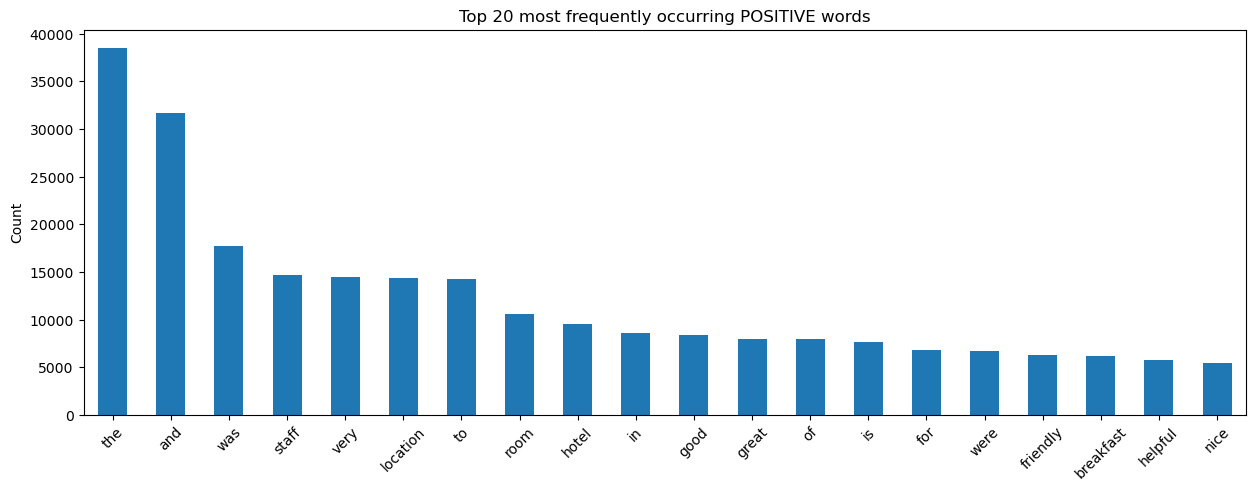

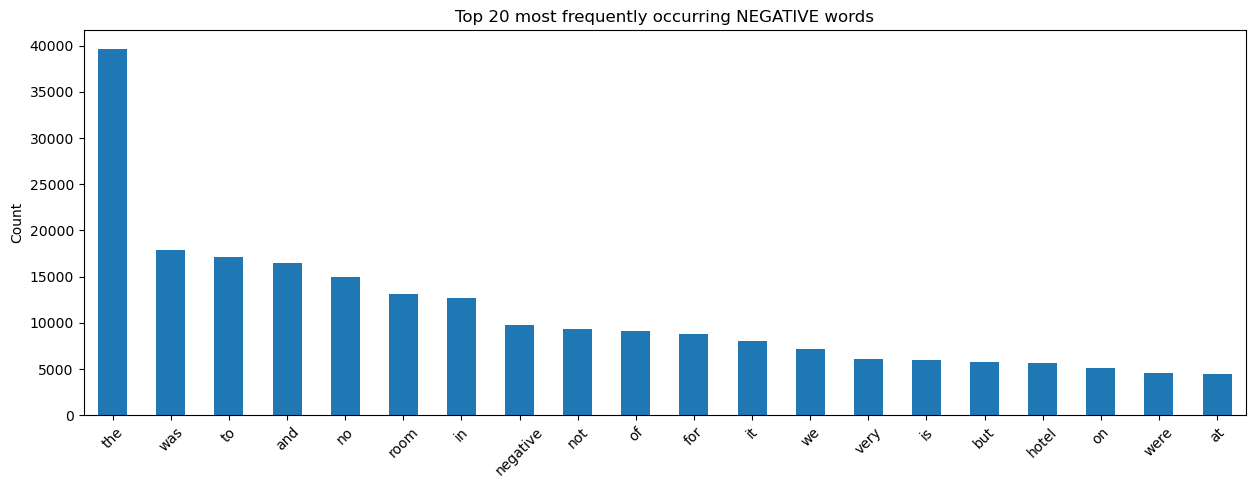

In [89]:
word_counts = pd.DataFrame(
    {"counts": X_pos_train.toarray().sum(axis=0)}, index=pos_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring POSITIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

word_counts = pd.DataFrame(
    {"counts": X_neg_train.toarray().sum(axis=0)}, index=neg_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring NEGATIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

---

Unsurprisingly the most commonly used words are "Stop Words" or words that do not contain much content or enrich our understanding of the text. Let use the `countvectorizer` stopwords function to take these away. For space sake, we will now combine our fit and transform operations in the same cell.

---

#### Vectorization Try 1

In [90]:
pos_vectorizer = CountVectorizer(stop_words='english')
neg_vectorizer = CountVectorizer(stop_words='english')

pos_vectorizer.fit(X_train['Positive_Review'])
neg_vectorizer.fit(X_train['Negative_Review'])

X_pos_train = pos_vectorizer.transform(X_train['Positive_Review'])
X_pos_test = pos_vectorizer.transform(X_test['Positive_Review'])
X_neg_train = neg_vectorizer.transform(X_train['Negative_Review'])
X_neg_test = neg_vectorizer.transform(X_test['Negative_Review'])


In [91]:
X_pos_train

<38679x13235 sparse matrix of type '<class 'numpy.int64'>'
	with 334537 stored elements in Compressed Sparse Row format>

In [92]:
X_neg_train

<38679x15319 sparse matrix of type '<class 'numpy.int64'>'
	with 291398 stored elements in Compressed Sparse Row format>

---

We can see that we have dropped a few hundred words from each of the text vocabularies, now that we got rid of the stop words lets check what our most common words are:

---

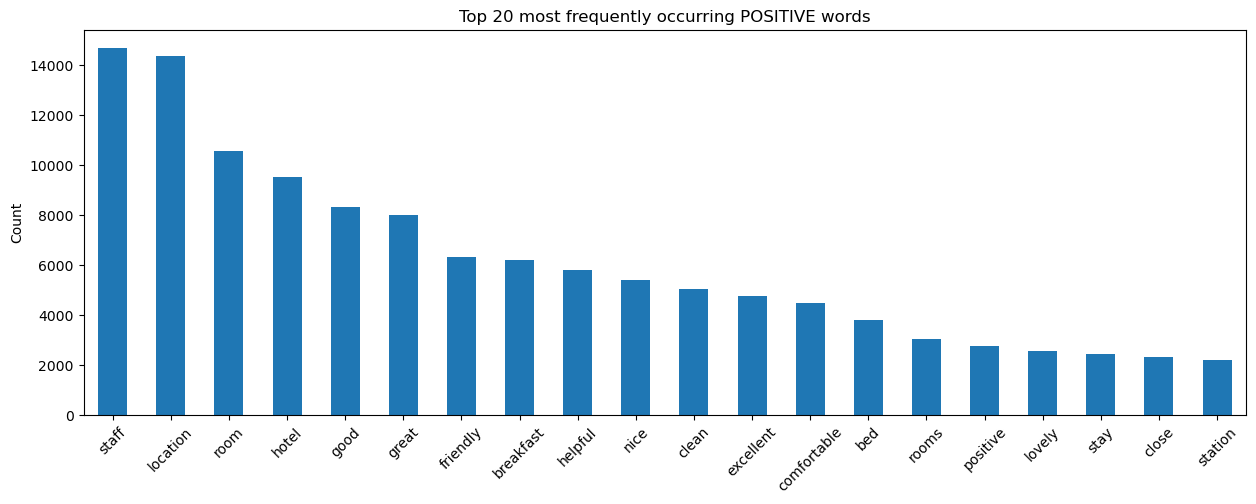

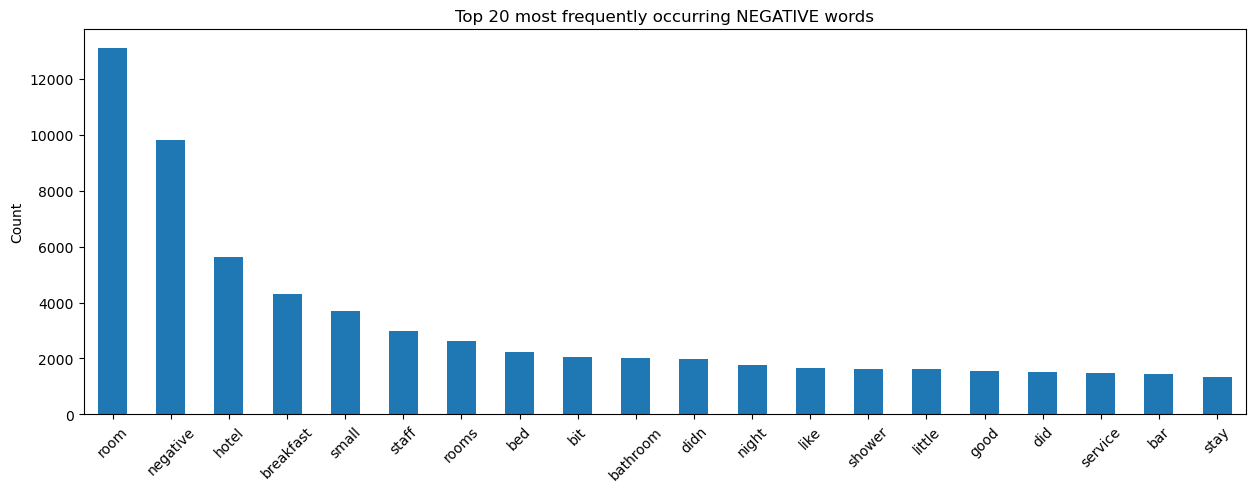

In [93]:
word_counts = pd.DataFrame(
    {"counts": X_pos_train.toarray().sum(axis=0)}, index=pos_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring POSITIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

word_counts = pd.DataFrame(
    {"counts": X_neg_train.toarray().sum(axis=0)}, index=neg_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring NEGATIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

---

Now we can see words that more accuarately represent the sentiments of a `Positive` or a `Negative` review.

We still have alot of dimensionality in our dataset, over 20K columns, that a lot to deal with and we havent even encoded our categorical columns yet. Lets try and solve this with `min_df`.

---

---

#### Question 3.E

What does the min_df parameter do?

---


---
`min_df` is a parameter that allows you to `specify the minimum number of documents a word must be present in for it to be included as a feature`. Essentially it is a filter used to decrease infrequent terms that may not add much value to the analysis. 

We can set it as an integer which allows you to set it to the exact amount of documents a word must appear in to be included, i.e a `min_df = 5` would be a `word that appeared in at least 5 documents`. Other wise you can set a float which would represent a proportion of the total number of documents, i.e `min_df =.01` would mean that the `word appeared in at least 1% of all documents` to be included. 

---


---

#### Important

With this in mind, we need to find a way to decide on what value we should set our min_df to. We were not told to run any models or do any `hyperparameter optimization` in this deliverable, but I would like to state that if I was making this choice in a real life situation I would likely use something along the lines of `Grid Search`, `Randomized Search` or some form of `Bayesian Optimization` to fine tune the hyperparamters of multiple models with min_df set as a feature to work through to find the best number to set it to.

However, without runnning a model there are a few `manual approaches` that would be more benefical to use with some `domain experience`.

---

---

Lets start by setting our `min_df to 5`. After researching online it says `5 and 10` are good places to start from. The lower the number the more words are included raising the potential of overfitting in the model as well as creating more dimensionality. Raise the number too high and you risk the chance of missing out on sentiment that could help classify a good or bad sentiment.

---

#### Vectorization Try 2

In [94]:
pos_vectorizer = CountVectorizer(min_df = 5,stop_words='english')
neg_vectorizer = CountVectorizer(min_df = 5,stop_words='english')

pos_vectorizer.fit(X_train['Positive_Review'])
neg_vectorizer.fit(X_train['Negative_Review'])

X_pos_train = pos_vectorizer.transform(X_train['Positive_Review'])
X_pos_test = pos_vectorizer.transform(X_test['Positive_Review'])
X_neg_train = neg_vectorizer.transform(X_train['Negative_Review'])
X_neg_test = neg_vectorizer.transform(X_test['Negative_Review'])

---

Lets see what this get us down too.

---

In [95]:
print(X_pos_train.shape)
print(X_neg_test.shape)

(38679, 3455)
(12894, 4362)


---

This is a big decrease, from over `10K to under 5K` for each of the vocabularies. Lets look at both the top 20 kept and the top 20 dropped words...in order to see the dropped words we have to create a list comprehension to make a DF of dropped words.

---

In [96]:
# Get the retained words for positive and negative vectorizers
retained_words_pos = pos_vectorizer.get_feature_names_out()
retained_words_neg = neg_vectorizer.get_feature_names_out()

# Get the original list of words from your documents
original_words_pos = []
original_words_neg = []

for document in X_train['Positive_Review']:
    original_words_pos.extend(document.split())

for document in X_train['Negative_Review']:
    original_words_neg.extend(document.split())

# Identify the dropped words by comparing original words with retained words
dropped_words_pos = [word for word in original_words_pos if word not in retained_words_pos]
dropped_words_neg = [word for word in original_words_neg if word not in retained_words_neg]

# Create dataframes for dropped words
pos_dropped_df = pd.DataFrame({"dropped_words": dropped_words_pos})
neg_dropped_df = pd.DataFrame({"dropped_words": dropped_words_neg})

<Axes: xlabel='dropped_words'>

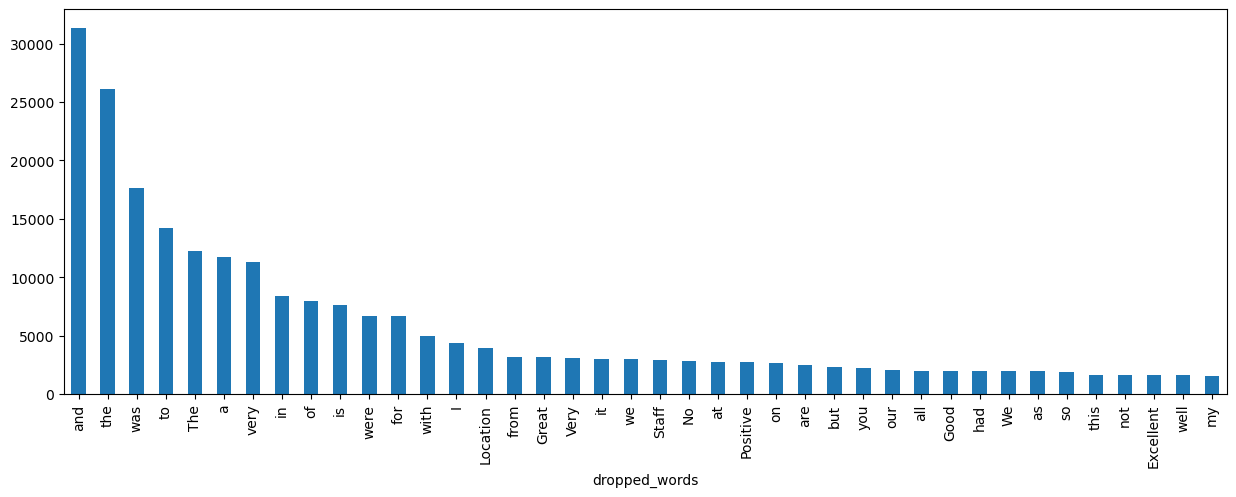

In [97]:
pos_dropped_df['dropped_words'].value_counts().head(40).plot(kind="bar", figsize=(15, 5), legend=False)

<Axes: xlabel='dropped_words'>

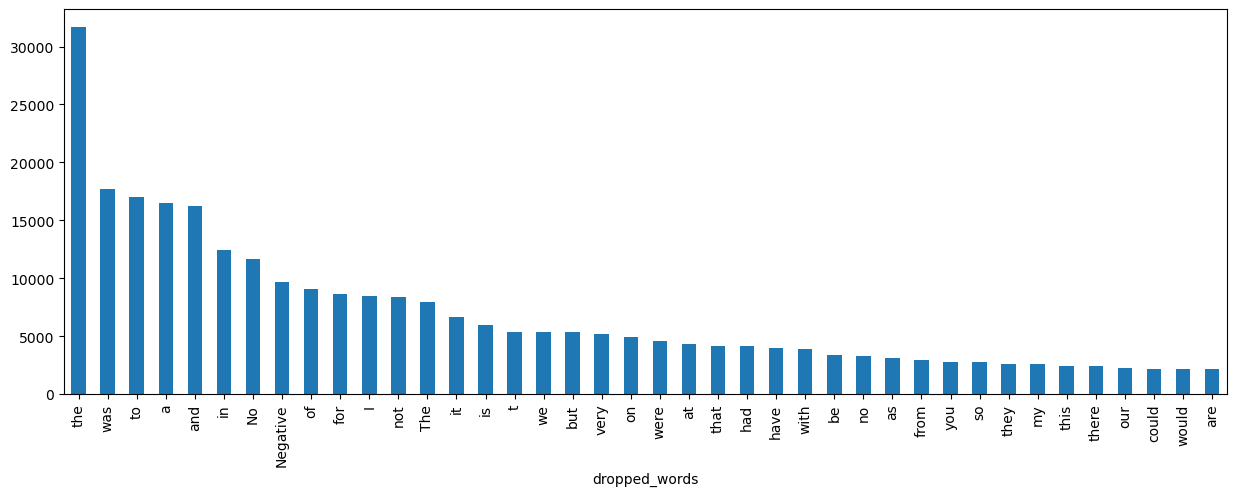

In [98]:
neg_dropped_df['dropped_words'].value_counts().head(40).plot(kind="bar", figsize=(15, 5), legend=False)

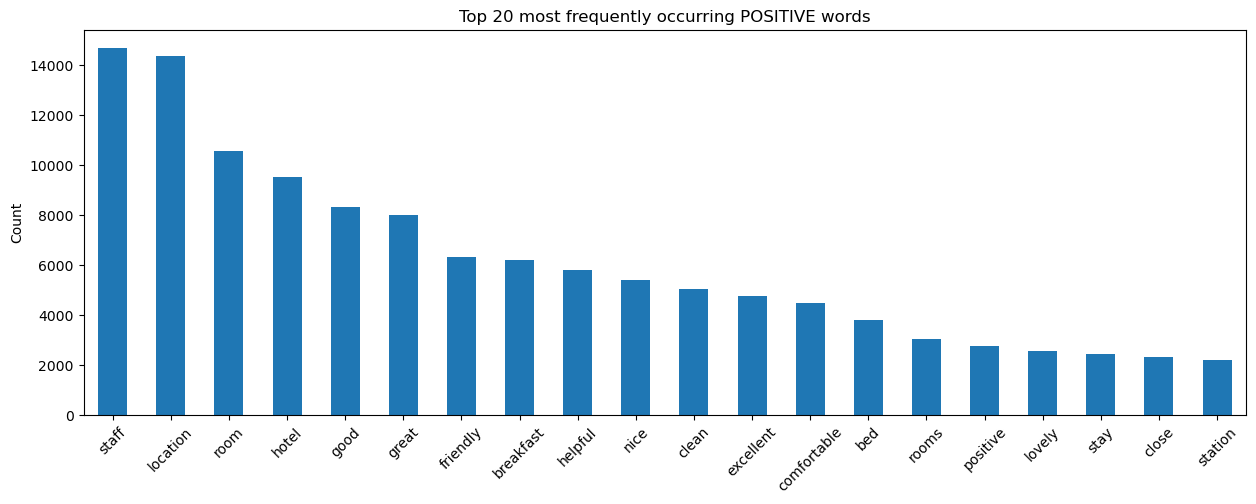

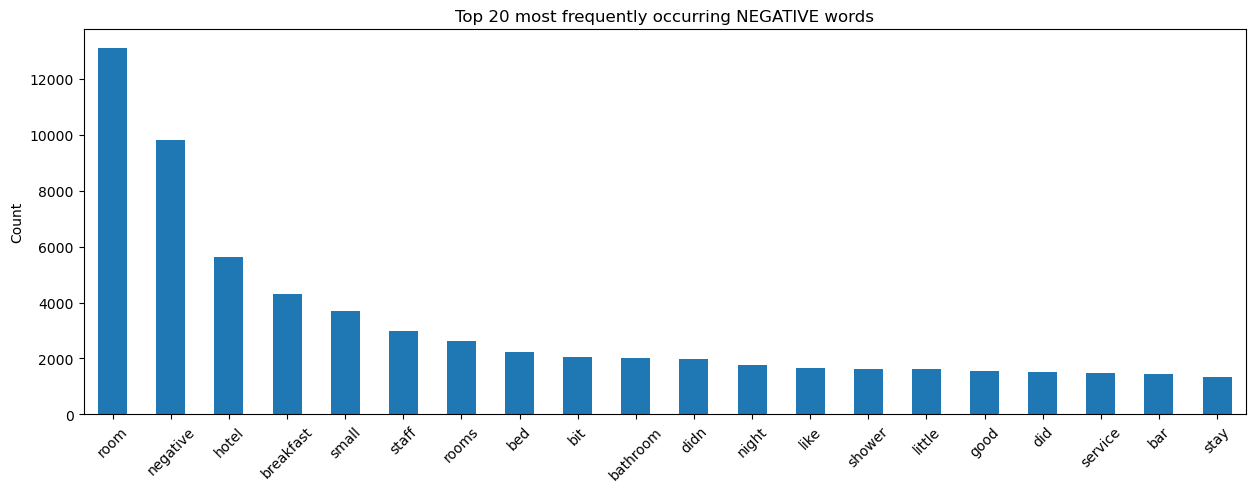

In [99]:
word_counts = pd.DataFrame(
    {"counts": X_pos_train.toarray().sum(axis=0)}, index=pos_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring POSITIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

word_counts = pd.DataFrame(
    {"counts": X_neg_train.toarray().sum(axis=0)}, index=neg_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring NEGATIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

---

As expected many of the words are stop words that are dropped but a few that should be kept are being filtered because of capitalization...lets lowercase the set the words to lowercase.

---

#### Vectorization Try 3

In [100]:
X_train['Positive_Review'] = [text.lower() for text in X_train['Positive_Review']]
X_train['Negative_Review'] = [text.lower() for text in X_train['Negative_Review']]
X_test['Positive_Review'] = [text.lower() for text in X_test['Positive_Review']]
X_test['Negative_Review'] = [text.lower() for text in X_test['Negative_Review']]

pos_vectorizer = CountVectorizer(min_df = 5,stop_words='english')
neg_vectorizer = CountVectorizer(min_df = 5,stop_words='english')

pos_vectorizer.fit(X_train['Positive_Review'])
neg_vectorizer.fit(X_train['Negative_Review'])

X_pos_train = pos_vectorizer.transform(X_train['Positive_Review'])
X_pos_test = pos_vectorizer.transform(X_test['Positive_Review'])
X_neg_train = neg_vectorizer.transform(X_train['Negative_Review'])
X_neg_test = neg_vectorizer.transform(X_test['Negative_Review'])

In [101]:
# Get the retained words for positive and negative vectorizers
retained_words_pos = pos_vectorizer.get_feature_names_out()
retained_words_neg = neg_vectorizer.get_feature_names_out()

# Get the original list of words from your documents
original_words_pos = []
original_words_neg = []

for document in X_train['Positive_Review']:
    original_words_pos.extend(document.split())

for document in X_train['Negative_Review']:
    original_words_neg.extend(document.split())

# Identify the dropped words by comparing original words with retained words
dropped_words_pos = [word for word in original_words_pos if word not in retained_words_pos]
dropped_words_neg = [word for word in original_words_neg if word not in retained_words_neg]

# Create dataframes for dropped words
pos_dropped_df = pd.DataFrame({"dropped_words": dropped_words_pos})
neg_dropped_df = pd.DataFrame({"dropped_words": dropped_words_neg})

<Axes: xlabel='dropped_words'>

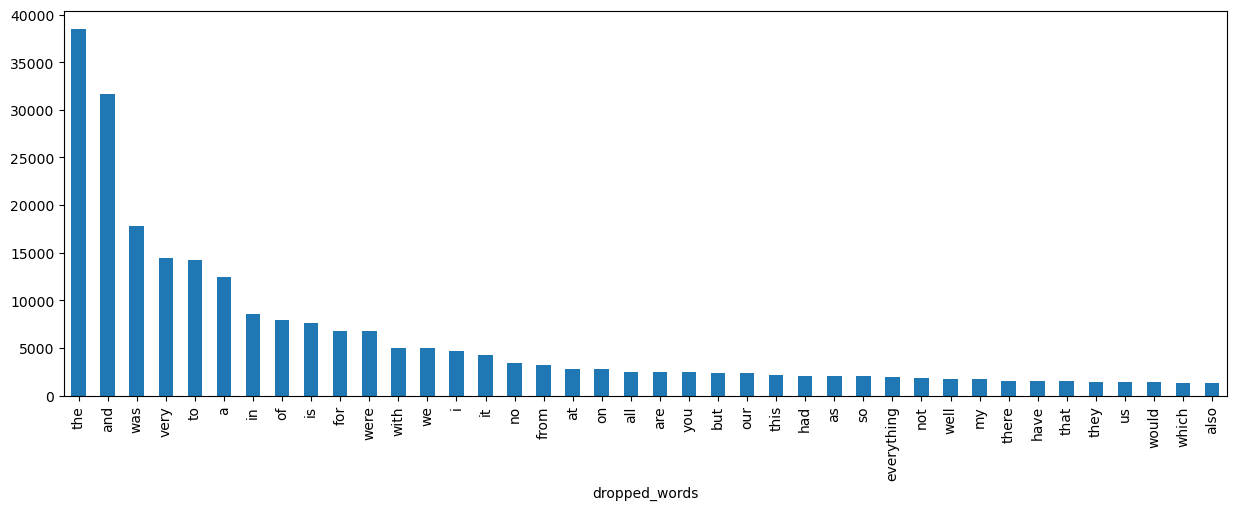

In [102]:
pos_dropped_df['dropped_words'].value_counts().head(40).plot(kind="bar", figsize=(15, 5), legend=False)

<Axes: xlabel='dropped_words'>

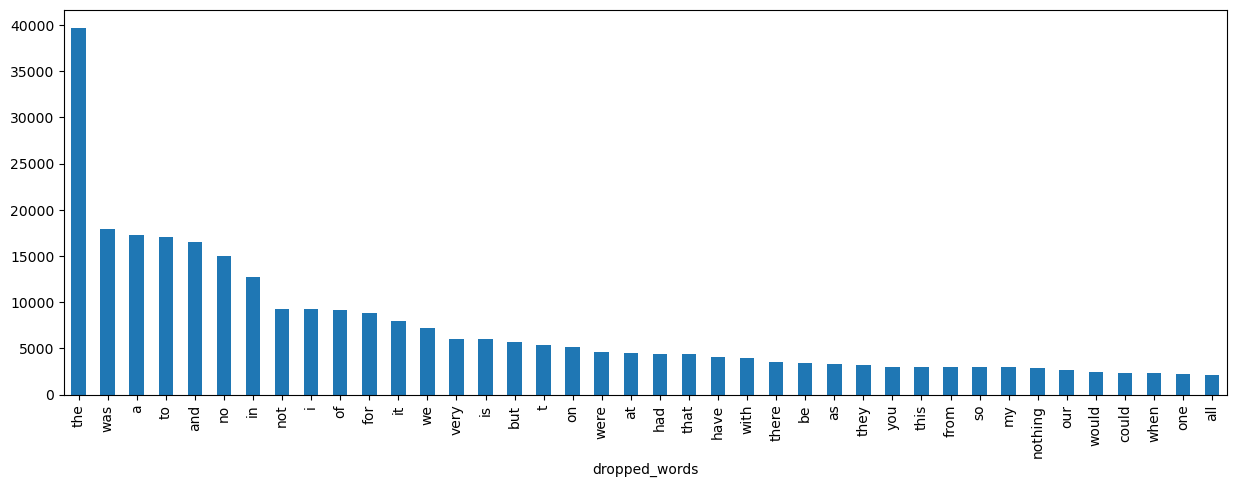

In [103]:
neg_dropped_df['dropped_words'].value_counts().head(40).plot(kind="bar", figsize=(15, 5), legend=False)

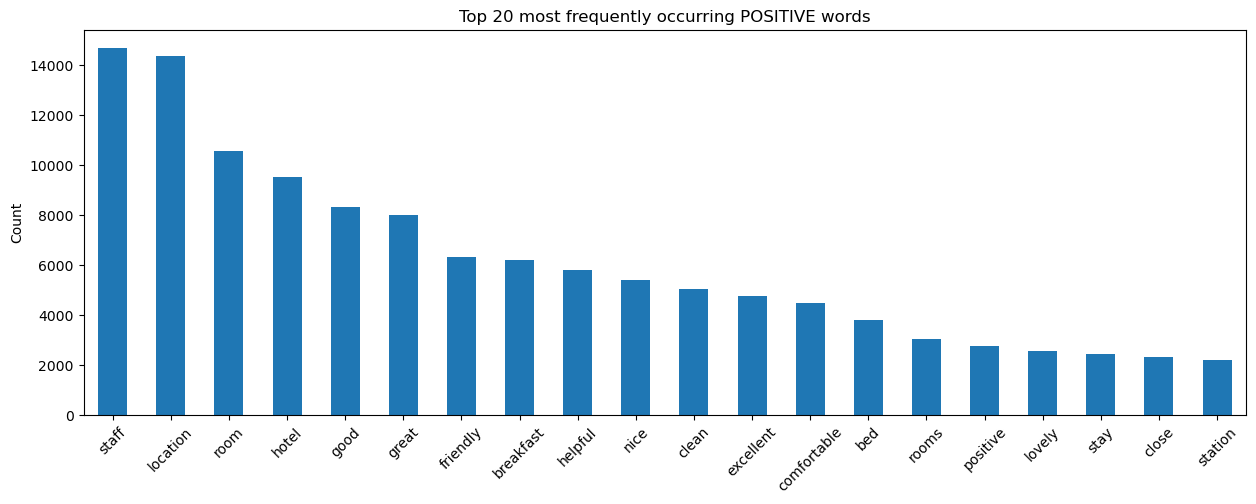

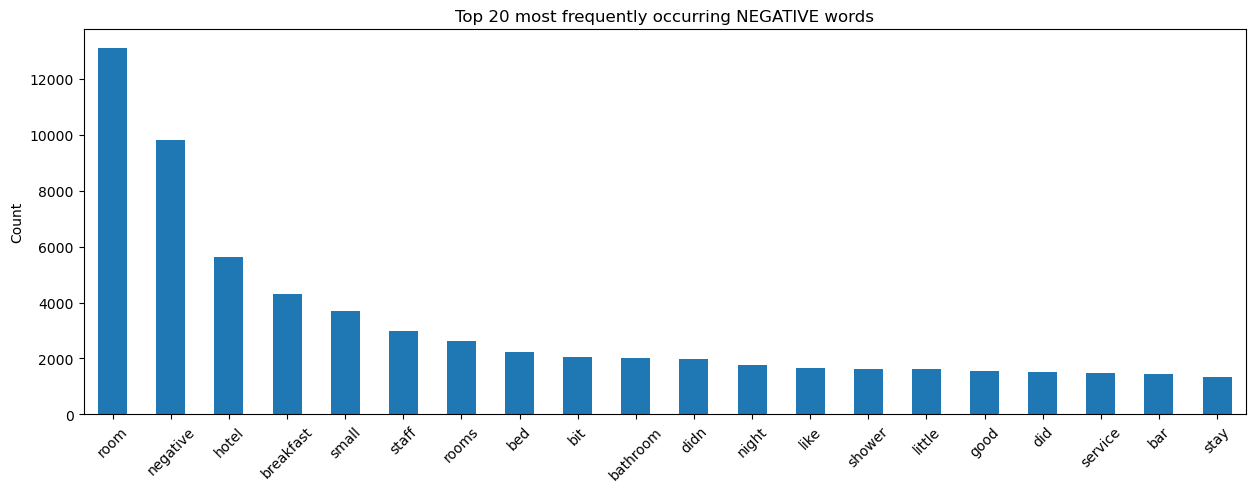

In [104]:
word_counts = pd.DataFrame(
    {"counts": X_pos_train.toarray().sum(axis=0)}, index=pos_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring POSITIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

word_counts = pd.DataFrame(
    {"counts": X_neg_train.toarray().sum(axis=0)}, index=neg_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring NEGATIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

---

I think before we work on the min_df anymore lets play around with `n-grams` this allows us to capture combinations of words, like `"not great"`  and `"didnt like"`, this could increase our token count but lets give it a try and see what happens. 

We will start with `bi-grams`, or sequential words of two.

---

#### Vectorization Try 4

In [105]:
X_train['Positive_Review'] = [text.lower() for text in X_train['Positive_Review']]
X_train['Negative_Review'] = [text.lower() for text in X_train['Negative_Review']]
X_test['Positive_Review'] = [text.lower() for text in X_test['Positive_Review']]
X_test['Negative_Review'] = [text.lower() for text in X_test['Negative_Review']]

pos_vectorizer = CountVectorizer(min_df = 5,stop_words='english',ngram_range=(1,2))
neg_vectorizer = CountVectorizer(min_df = 5,stop_words='english',ngram_range=(1,2))

pos_vectorizer.fit(X_train['Positive_Review'])
neg_vectorizer.fit(X_train['Negative_Review'])

X_pos_train = pos_vectorizer.transform(X_train['Positive_Review'])
X_pos_test = pos_vectorizer.transform(X_test['Positive_Review'])
X_neg_train = neg_vectorizer.transform(X_train['Negative_Review'])
X_neg_test = neg_vectorizer.transform(X_test['Negative_Review'])

In [106]:
print(X_pos_train.shape)
print(X_neg_train.shape)

(38679, 11197)
(38679, 10791)


In [107]:
# Get the retained words for positive and negative vectorizers
retained_words_pos = pos_vectorizer.get_feature_names_out()
retained_words_neg = neg_vectorizer.get_feature_names_out()

# Get the original list of words from your documents
original_words_pos = []
original_words_neg = []

for document in X_train['Positive_Review']:
    original_words_pos.extend(document.split())

for document in X_train['Negative_Review']:
    original_words_neg.extend(document.split())

# Identify the dropped words by comparing original words with retained words
dropped_words_pos = [word for word in original_words_pos if word not in retained_words_pos]
dropped_words_neg = [word for word in original_words_neg if word not in retained_words_neg]

# Create dataframes for dropped words
pos_dropped_df = pd.DataFrame({"dropped_words": dropped_words_pos})
neg_dropped_df = pd.DataFrame({"dropped_words": dropped_words_neg})

<Axes: xlabel='dropped_words'>

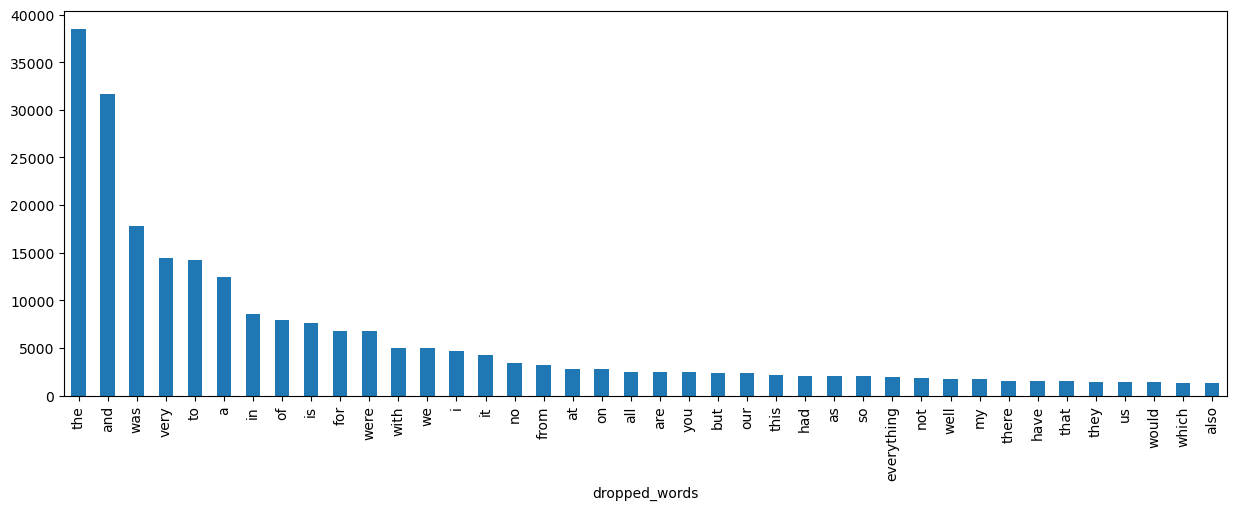

In [108]:
pos_dropped_df['dropped_words'].value_counts().head(40).plot(kind="bar", figsize=(15, 5), legend=False)

<Axes: xlabel='dropped_words'>

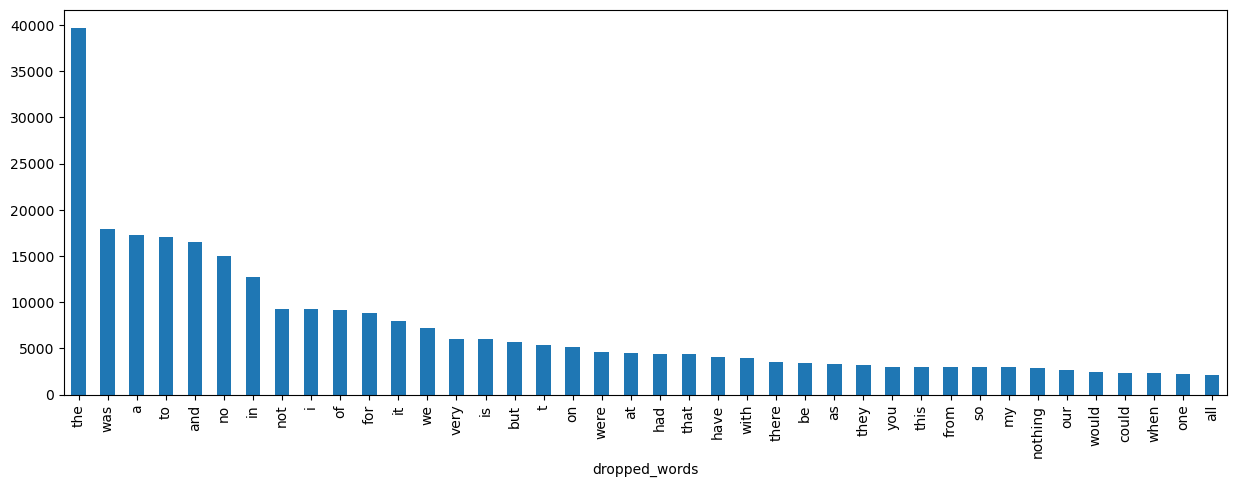

In [109]:
neg_dropped_df['dropped_words'].value_counts().head(40).plot(kind="bar", figsize=(15, 5), legend=False)

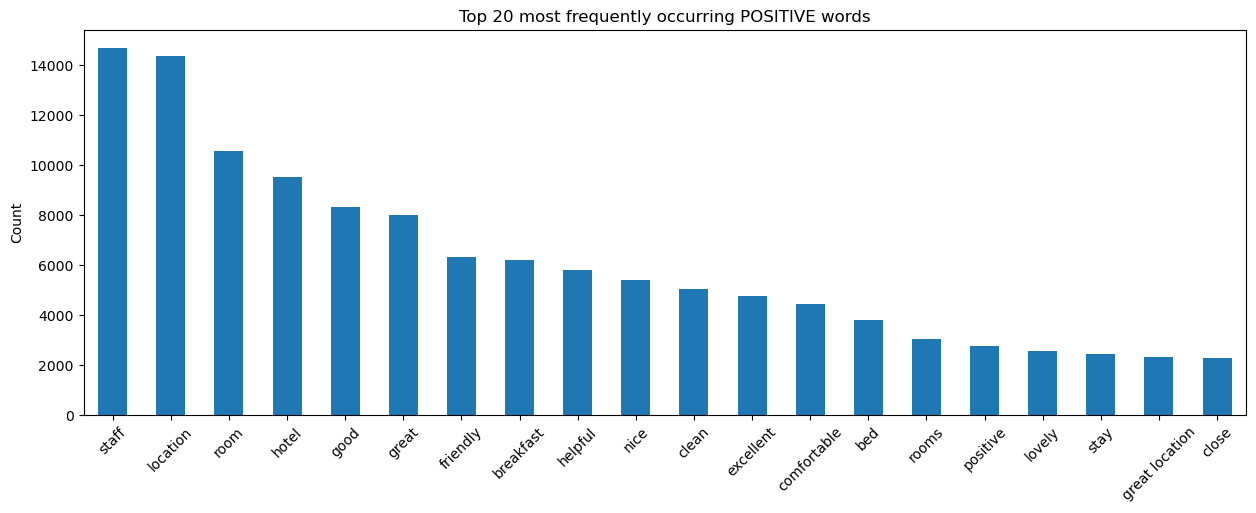

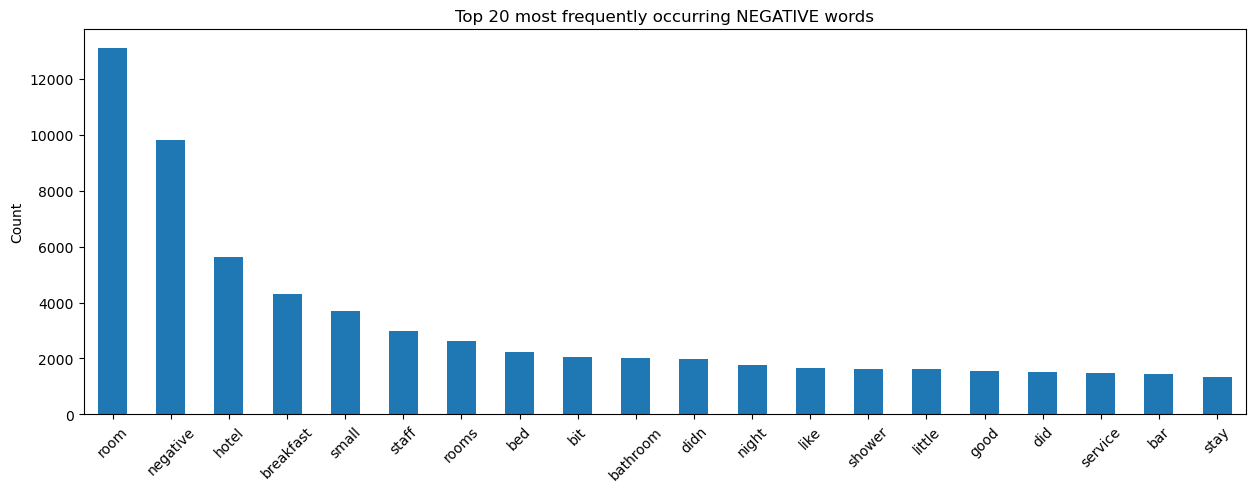

In [110]:
word_counts = pd.DataFrame(
    {"counts": X_pos_train.toarray().sum(axis=0)}, index=pos_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring POSITIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

word_counts = pd.DataFrame(
    {"counts": X_neg_train.toarray().sum(axis=0)}, index=neg_vectorizer.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring NEGATIVE words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

---

So we something interesting, which is something I didnt expect. In our EDA we only have one `bi-gram` that shows up...as well, our dimensionality has vastly increased. It would only really be able to tell with a model but from my observations I dont think the computational resources used for this will drastically change the accuracy of a model by using n-grams. I believe we will leave them out. 

I will try one more option to see if it could make a potential difference. Lets use the float paramter on min_df set a certain percentage. Lets do a little math here to see where we should start.

---

In [111]:
5/38679

0.000129269112438274

---

A `min_df of 5` represents about `.01%` of the text data. This leads me to believe that we need to keep our percentage low, but for instance, what if we went up to `.1%`, how much of a significant difference would this make?


Lets find out.

---

#### Vectorization Try 5


In [112]:
X_train['Positive_Review'] = [text.lower() for text in X_train['Positive_Review']]
X_train['Negative_Review'] = [text.lower() for text in X_train['Negative_Review']]
X_test['Positive_Review'] = [text.lower() for text in X_test['Positive_Review']]
X_test['Negative_Review'] = [text.lower() for text in X_test['Negative_Review']]

pos_vectorizer = CountVectorizer(min_df = .001, stop_words='english')
neg_vectorizer = CountVectorizer(min_df = .001, stop_words='english')

pos_vectorizer.fit(X_train['Positive_Review'])
neg_vectorizer.fit(X_train['Negative_Review'])

X_pos_train = pos_vectorizer.transform(X_train['Positive_Review'])
X_pos_test = pos_vectorizer.transform(X_test['Positive_Review'])
X_neg_train = neg_vectorizer.transform(X_train['Negative_Review'])
X_neg_test = neg_vectorizer.transform(X_test['Negative_Review'])

In [113]:
X_pos_train

<38679x941 sparse matrix of type '<class 'numpy.int64'>'
	with 287105 stored elements in Compressed Sparse Row format>

In [114]:
X_neg_train

<38679x1131 sparse matrix of type '<class 'numpy.int64'>'
	with 231859 stored elements in Compressed Sparse Row format>

In [115]:
.001 * 38679

38.679

---

So with a `min_df` of `.1%` we are setting our paramter to make sure that each word occurs in at least `~39` different documents in our `corpus`.

This seems like a reasonable number of features to work with. I am happy with where this leaves us without using `Grid Search`,`Random Saerch` or any `Bayesian Optimization`. I think now we should put all of the data tgether now to finalize our dataset.

First lets take a look at the DF and make sure we dont have any more columns to drop before we use the `Column Transform` methodology to combine everything together in a matrix.

---

In [116]:
sampled_df.head()

Additional_Number_of_Scoring  Average_Score        Reviewer_Nationality  \
0                           110            7.6   United States of America    
1                           164            8.9             United Kingdom    
2                          1258            9.4             United Kingdom    
3                           109            8.7                Netherlands    
4                           545            8.0             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

   days_since_review        lat        lng         Country       City  Year  \
0                658  48.855427   2.415256          France      Paris  2015   
1                506  48.197998  16.348331         Austria     Vienna  2016   
2                469  51.502435  -0.000250  United Kingdom     London  2016   
3                319  41.370304   2.171410           Spain  Barcelona  2016   
4                652  51.512397  -0.186124  United Kingdom     London  2015   

   Quarter  Month Day_of_Week      Trip_Type              Guest_Type  \
0        4     10    Thursday   Leisure trip                  Couple   
1        1      3     Tuesday   Leisure trip                   Group   
2        2      4    Thursday   Leisure trip  Travelers with friends   
3        3      9      Sunday   Leisure trip                  Couple   
4        4     10   Wednesday  Business trip           Solo traveler   

     Nights_Stayed Room_Category  
0  Stayed 3 nights        Single  
1   Stayed 1 night         Suite  
2   Stayed 1 night          King  
3  Stayed 2 nights         Suite  
4   Stayed 1 night        Double

---

As I stated earlier, I beleive that `Country` is redundant information as that is obviously captured by the more granular `City` column. As well, `Quarter` had very little variance in its distribution and I believe that it may not be necessary to keep for the sake of dimensionality.

Lets drop these and continue on.

---

In [117]:
sampled_df.drop(['Country','Quarter'], axis=1, inplace=True)

In [118]:
sampled_df.head()

Additional_Number_of_Scoring  Average_Score        Reviewer_Nationality  \
0                           110            7.6   United States of America    
1                           164            8.9             United Kingdom    
2                          1258            9.4             United Kingdom    
3                           109            8.7                Netherlands    
4                           545            8.0             United Kingdom    

                                     Negative_Review  \
0   Worst Hotel Ever If you know what s good for ...   
1                                        No Negative   
2   They charged me double for the room for some ...   
3   Horrible staff They simply ly to you and do n...   
4                       Awful awful hotel experience   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                219                     1176   
1                                  0                     1887   
2                                 59                     4204   
3                                 77                      977   
4                                  5                     2907   

                                     Positive_Review  \
0           I didn t like anything on this property    
1   Great location 15 min walk from old town and ...   
2                                        No Positive   
3                                        No Positive   
4                                        No Positive   

   Review_Total_Positive_Word_Counts  \
0                                 10   
1                                 35   
2                                  0   
3                                  0   
4                                  0   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           2               0   
1                                           2               0   
2                                           1               0   
3                                          11               0   
4                                           1               0   

   days_since_review        lat        lng       City  Year  Month  \
0                658  48.855427   2.415256      Paris  2015     10   
1                506  48.197998  16.348331     Vienna  2016      3   
2                469  51.502435  -0.000250     London  2016      4   
3                319  41.370304   2.171410  Barcelona  2016      9   
4                652  51.512397  -0.186124     London  2015     10   

  Day_of_Week      Trip_Type              Guest_Type    Nights_Stayed  \
0    Thursday   Leisure trip                  Couple  Stayed 3 nights   
1     Tuesday   Leisure trip                   Group   Stayed 1 night   
2    Thursday   Leisure trip  Travelers with friends   Stayed 1 night   
3      Sunday   Leisure trip                  Couple  Stayed 2 nights   
4   Wednesday  Business trip           Solo traveler   Stayed 1 night   

  Room_Category  
0        Single  
1         Suite  
2          King  
3         Suite  
4        Double

In [119]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51573 entries, 0 to 51572
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Additional_Number_of_Scoring                51573 non-null  int64  
 1   Average_Score                               51573 non-null  float64
 2   Reviewer_Nationality                        51573 non-null  object 
 3   Negative_Review                             51573 non-null  object 
 4   Review_Total_Negative_Word_Counts           51573 non-null  int64  
 5   Total_Number_of_Reviews                     51573 non-null  int64  
 6   Positive_Review                             51573 non-null  object 
 7   Review_Total_Positive_Word_Counts           51573 non-null  int64  
 8   Total_Number_of_Reviews_Reviewer_Has_Given  51573 non-null  int64  
 9   Reviewer_Score                              51573 non-null  int64  
 10  days_since

---

So we now have our extracted semi-final dataset that we will encode with all uneccesary columns dropped. 

Lets use `Column Trasnform`, a feature from SKlearn that allows us apply different feature extraction techniques. We can use it to perform the `One-Hot-Encoding` and `Vectorization` on the appropriate columns.

---

In [120]:
# Select columns for different types of transformations
categorical_cols = ['Reviewer_Nationality', 'City', 'Year', 'Month', 'Day_of_Week', 'Trip_Type', 'Guest_Type', 'Nights_Stayed', 'Room_Category']
positive_text_col = 'Positive_Review'
negative_text_col = 'Negative_Review'
numerical_cols = ['Additional_Number_of_Scoring', 'days_since_review', 'lat', 'lng', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews', 'Average_Score']

# Define column transformations for categorical and text features,
# use the parameters for min_df that we defined earlier,
# make sure to use the passthrough option as we don't want to transform the numerical features
col_transforms = [
    ('numerical_cols','passthrough', numerical_cols),
    ('categorical_transforms', OneHotEncoder(drop='first'), categorical_cols),
    ('pos_transforms', CountVectorizer(min_df=.001, stop_words='english'), positive_text_col),
    ('neg_transforms', CountVectorizer(min_df=.001, stop_words='english'), negative_text_col)
]

# Split the Data with a 75/25 split and a random state of 42 for reproducibility
X = sampled_df.drop('Reviewer_Score', axis=1)
y = sampled_df['Reviewer_Score']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Instantiate the ColumnTransformer
col_trans = ColumnTransformer(transformers=col_transforms)

# Apply column transformer to X_train for categorical and text features 
X_train_fit = col_trans.fit(X_train)

# create the arrays of transformed features
X_train_combined = X_train_fit.transform(X_train)
X_test_combined = col_trans.transform(X_test)

# train_transformed_df = pd.DataFrame(X_train_combined.todense(), columns=col_trans.get_feature_names_out())
# test_transformed_df = pd.DataFrame(X_test_combined.todense(), columns=col_trans.get_feature_names_out())
print(X_train_combined)
print(X_test_combined)



  (0, 0)	294.0
  (0, 1)	115.0
  (0, 2)	51.5139315
  (0, 3)	-0.1219893
  (0, 4)	2.0
  (0, 5)	5.0
  (0, 6)	10.0
  (0, 7)	1271.0
  (0, 8)	8.7
  (0, 40)	1.0
  (0, 44)	1.0
  (0, 49)	1.0
  (0, 52)	1.0
  (0, 61)	1.0
  (0, 67)	1.0
  (0, 72)	1.0
  (0, 83)	1.0
  (0, 571)	1.0
  (0, 573)	1.0
  (0, 647)	1.0
  (0, 689)	1.0
  (0, 868)	1.0
  (1, 0)	520.0
  (1, 1)	491.0
  (1, 2)	52.3663466
  :	:
  (38677, 1845)	1.0
  (38677, 1860)	2.0
  (38677, 1933)	1.0
  (38677, 2039)	1.0
  (38677, 2057)	1.0
  (38677, 2119)	1.0
  (38678, 0)	106.0
  (38678, 1)	535.0
  (38678, 2)	48.2006001
  (38678, 3)	16.3386333
  (38678, 5)	1.0
  (38678, 6)	11.0
  (38678, 7)	1886.0
  (38678, 8)	8.2
  (38678, 25)	1.0
  (38678, 47)	1.0
  (38678, 48)	1.0
  (38678, 50)	1.0
  (38678, 61)	1.0
  (38678, 72)	1.0
  (38678, 183)	1.0
  (38678, 541)	1.0
  (38678, 831)	1.0
  (38678, 969)	1.0
  (38678, 1686)	1.0
  (0, 0)	360.0
  (0, 1)	256.0
  (0, 2)	51.475172
  (0, 3)	-0.1870629
  (0, 4)	7.0
  (0, 5)	2.0
  (0, 6)	10.0
  (0, 7)	1181.0
  (0, 8)	8.

---

Now lets turn into a DF for a little bit of exploration and to double check its all working appropriately.

---

In [121]:
train_transformed_df = pd.DataFrame(X_train_combined.todense(), columns=col_trans.get_feature_names_out())
test_transformed_df = pd.DataFrame(X_test_combined.todense(), columns=col_trans.get_feature_names_out())

In [122]:
train_transformed_df.head()

numerical_cols__Additional_Number_of_Scoring  \
0                                         294.0   
1                                         520.0   
2                                          56.0   
3                                         164.0   
4                                         374.0   

   numerical_cols__days_since_review  numerical_cols__lat  \
0                              115.0            51.513931   
1                              491.0            52.366347   
2                              490.0            48.887057   
3                              150.0            48.207529   
4                              294.0            48.206227   

   numerical_cols__lng  numerical_cols__Review_Total_Negative_Word_Counts  \
0            -0.121989                                                2.0   
1             4.898576                                               33.0   
2             2.314330                                              112.0   
3            16.352597                                                0.0   
4            16.383377                                               17.0   

   numerical_cols__Total_Number_of_Reviews_Reviewer_Has_Given  \
0                                                5.0            
1                                                7.0            
2                                                1.0            
3                                               30.0            
4                                               17.0            

   numerical_cols__Review_Total_Positive_Word_Counts  \
0                                               10.0   
1                                                7.0   
2                                               15.0   
3                                               14.0   
4                                                6.0   

   numerical_cols__Total_Number_of_Reviews  numerical_cols__Average_Score  \
0                                   1271.0                            8.7   
1                                   2591.0                            7.8   
2                                    859.0                            7.6   
3                                   1120.0                            9.3   
4                                   3078.0                            8.0   

   categorical_transforms__Reviewer_Nationality_ Austria   \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   categorical_transforms__Reviewer_Nationality_ Belgium   \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   categorical_transforms__Reviewer_Nationality_ Canada   \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   categorical_transforms__Reviewer_Nationality_ China   \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                                0.0      
4                                                0.0      

   categorical_transforms__Reviewer_Nationality_ Czech Republic   \
0                                                0.0               
1                                                0.0               
2                    

In [123]:
test_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12894 entries, 0 to 12893
Columns: 2158 entries, numerical_cols__Additional_Number_of_Scoring to neg_transforms__young
dtypes: float64(2158)
memory usage: 212.3 MB


In [124]:
train_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38679 entries, 0 to 38678
Columns: 2158 entries, numerical_cols__Additional_Number_of_Scoring to neg_transforms__young
dtypes: float64(2158)
memory usage: 636.8 MB


---

# Conclusion

#### We are all good!

Now at the end of this massive and labor intensive project we have a sparse matrix of our numerical and text data as well as a dense DF to examine the layout of the data.

We have in our Train Dataset:
- `~39K` Rows and `2167` columns

In our Test Dataset:
- `~13K` Rows and `2167` columns

There are many things I would have liked to have done regarding setting the parameters, but I believe this will be done with the next deliverable. I look forward to diving into the modeling aspect of this dataset.


---